### 基础库定义

In [ ]:
import pickle
import json
import base64
import io
import os
import sys
import time
from keras.optimizers import Adam, SGD, Adagrad  
from keras.models import Sequential, load_model
import matplotlib.image as mpimg  
from matplotlib import pyplot as plt  
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow import keras 
import tensorflow as tf  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import r2_score, mean_squared_error  
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split  
from scipy.stats import kurtosis  
from scipy.signal import hilbert, argrelextrema
from typing import Tuple, List
from keras.losses import MeanSquaredError
import sklearn
import pandas as pd
import numpy as np
from pandas import DataFrame
from io import BytesIO


def log(info: str):
    ''' log输出'''
    print(f"reservoirPredict->log:{info}")


def output(info: str):
    ''' 有关模型训练/预测的输出数据'''
    print(f"reservoirPredict->output:{info}")


def warn(info: str):
    ''' 警告信息 '''
    print(f"reservoirPredict->warn:{info}")


def error(info: str):
    ''' 出错信息'''
    print(f"reservoirPredict->error:{info}")


# 库导入
# 机器学习库
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Python:", sys.version)
print("All libraries imported successfully!")


def importMatplotlib():
    ''' 导入绘图库'''
    from matplotlib import pyplot as plt  # 导入绘图模块
    import matplotlib.image as mpimg  # 图像读取与保存模块
    import seaborn as sns  # 导入图表库
    sns.set_theme(style='white')  # 设置白色背景
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文文字设置为黑体
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.size'] = 12  # 字体大小
    plt.rcParams['xtick.labelsize'] = 16  # x刻度数字大小
    plt.rcParams['ytick.labelsize'] = 16  # y刻度数字大小
    plt.rcParams["axes.labelsize"] = 18  # 坐标轴文字大小
    return plt, sns


try:
    from pandas import DataFrame
    import numpy as np
    import pandas as pd
    output("加载:pandas")
    from scipy.signal import hilbert, argrelextrema
    from scipy.stats import kurtosis

    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.ensemble import RandomForestRegressor
    output("加载:sklearn")

    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    output("正在加载TensorFlow库")
    import tensorflow as tf
    from tensorflow import keras
    tf.random.set_seed(2024)
    from keras.models import Sequential, load_model
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
    from keras.optimizers import Adam, SGD, Adagrad
    from keras.losses import MeanSquaredError
    output("完成加载TensorFlow库")
    plt, sns = importMatplotlib()

except Exception as e:
    error(e)
    exit(1)


def getEvalutionData(y_train, y_train_pre, y_test, y_test_pre):
    y_train = np.array(y_train)
    evalution = {}
    evalution['train_r2_score'] = r2_score(y_train, y_train_pre)
    evalution['test_r2_score'] = r2_score(y_test, y_test_pre)
    evalution['train_mean_squared_error'] = mean_squared_error(
        y_train, y_train_pre)
    evalution['test_mean_squared_error'] = mean_squared_error(
        y_test, y_test_pre)

    if y_train.max() < 50:
        y_train_max = 50
    elif y_train.max() < 400:
        y_train_max = y_train.max()
    else:
        y_train_max = 400
    evalution['evalution_plot'] = getModelEvalutionPlot(
        y_train, y_train_pre, y_test, y_test_pre, 0, y_train_max)
    return evalution

def getModelEvalutionPlot(y_train, y_train_pred, y_test, y_test_pred, min_value=0, max_value=50):
    plt, sns = importMatplotlib()
    plt.figure(figsize=(10, 8))
    plt.scatter(y_train, y_train_pred, label="训练集")
    plt.scatter(y_test, y_test_pred, label="测试集")
    plt.plot([min_value, max_value], [min_value, max_value],
             color="red", linestyle='--')
    plt.xlabel('砂厚真实值')
    plt.ylabel('砂厚预测值')
    plt.tick_params(which="major", direction='in',
                    length=6, bottom=True, left=True)
    plt.xlim(min_value, max_value)
    plt.ylim(min_value, max_value)
    plt.legend()
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    base64_image = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()
    return base64_image


TensorFlow: 2.10.0
NumPy: 1.26.4
Pandas: 2.3.2
Python: 3.9.18 (main, Sep 11 2023, 13:30:38) [MSC v.1916 64 bit (AMD64)]
All libraries imported successfully!
reservoirPredict->output:加载:pandas
reservoirPredict->output:加载:sklearn
reservoirPredict->output:正在加载TensorFlow库
reservoirPredict->output:完成加载TensorFlow库


### 井数据整理

In [ ]:
import pandas as pd 
import numpy as np  

well_data = pd.read_csv("wellhead.csv")
well_data = well_data.rename(columns={'wellname': 'drillname', 'sum_depth': 'sand_thick'})

well_data = well_data.dropna(subset=['InLine', 'XLine']) 
well_data = well_data[np.isfinite(well_data['InLine']) & np.isfinite(well_data['XLine'])] 

attribute_names = ['RMS','TE','EHT','MAA','AAA','AA']

output_records = [] 
def safe_read_attribute_file(filepath):
    
    try:
        with open(filepath) as f:
            first_line = f.readline()   
            second_line = f.readline()  
        sep = '\t' if '\t' in first_line else '\s+'  
        
        df = pd.read_csv(
            filepath,
            sep=sep,                    
            engine='python',            
            skiprows=1,                 
            header=None,                
            names=['InLine', 'XLine', 'X_Coor', 'Y_Coor', 'Value'],  
            dtype={'InLine': int, 'XLine': int, 'Value': float},     
            on_bad_lines='warn'       
        )
        
        df = df.dropna(subset=['InLine', 'XLine', 'Value'])
        df = df[
            np.isfinite(df['InLine']) & 
            np.isfinite(df['XLine']) & 
            np.isfinite(df['Value'])
        ]
        return df
    
    except Exception as e:
        print(f"! 读取文件 {filepath} 失败: {str(e)}")
        return pd.DataFrame()  

for layername in well_data['surface'].unique():
    print(f"\n{'='*40}")
    print(f"处理层位: {layername}")
    print(f"{'='*40}")
    
    layer_wells = well_data[well_data['surface'] == layername].copy()
    
    for attr in attribute_names:
        try:
            seismic_attr = safe_read_attribute_file(
                f"attribute-小层/{layername}-{attr}.txt"
            )
           
            if seismic_attr.empty:
                print(f"! 警告: {layername}-{attr}.txt 无有效数据")
                continue
      
            seismic_index = seismic_attr.set_index(['InLine', 'XLine'])
            
            matched_data = [] 
            for i, well in layer_wells.iterrows():
                inline = int(well['InLine'])
                xline = int(well['XLine'])
                
                try:
                    value = seismic_index.loc[(inline, xline), 'Value']
                    record = {
                        '井名': well['drillname'],
                        '层位': layername,
                        '属性': attr,
                        'InLine': inline,
                        'XLine': xline,
                        '属性值': f"{value:.4f}",
                        '匹配状态': '成功'
                    }
                    well_data.loc[i, attr] = value
                except KeyError:
                    record = {
                        '井名': well['drillname'],
                        '层位': layername,
                        '属性': attr,
                        'InLine': inline,
                        'XLine': xline,
                        '属性值': "NaN",
                        '匹配状态': '失败'
                    }
                matched_data.append(record)
                output_records.append(record)
            
            match_df = pd.DataFrame(matched_data)
            print(f"\n{attr}属性匹配结果:")
            print(match_df[['井名', 'InLine', 'XLine', '属性值', '匹配状态']].to_string(index=False))
            
            success_count = match_df['匹配状态'].value_counts().get('成功', 0)
            fail_count = len(layer_wells) - success_count  
            match_stats = {
                '成功': success_count,
                '失败': fail_count
            }
            print("\n匹配统计:")
full_report = pd.DataFrame(output_records)
print("\n详细匹配记录:")
print(full_report[['井名', '层位', '属性', '属性值', '匹配状态']].to_string(index=False))

well_data.to_csv("final_well_data_with_seismic_coords.csv", index=False)
full_report.to_csv("matching_details_report.csv", index=False)

print("\n处理完成，已保存:")
print("- 带属性及地震道坐标的井数据: final_well_data_with_seismic_coords.csv")
print("- 详细匹配报告: matching_details_report.csv")


处理层位: p1f3

RMS属性匹配结果:
         井名  InLine  XLine    属性值 匹配状态
   tuantan1    2061   1263 0.0834   成功
    shapai7    1289   1679 0.2795   成功
  zhongjia1    1057   1799 0.2559   成功
zhuangshen1    5313   2575 0.2027   成功
  zhongtan1    6043   2453 0.1798   成功
  zhengtan1    2379   1703 0.1368   成功
   shashen1    3039   1781 0.1170   成功
    wantan1    5039   1653 0.2544   成功

匹配统计:
- 成功: 8口井 (100.0%)
- 失败: 0口井 (0.0%)

TE属性匹配结果:
         井名  InLine  XLine    属性值 匹配状态
   tuantan1    2061   1263 0.0207   成功
    shapai7    1289   1679 0.1023   成功
  zhongjia1    1057   1799 0.1066   成功
zhuangshen1    5313   2575 0.1426   成功
  zhongtan1    6043   2453 0.0492   成功
  zhengtan1    2379   1703 0.0721   成功
   shashen1    3039   1781 0.1043   成功
    wantan1    5039   1653 0.0648   成功

匹配统计:
- 成功: 8口井 (100.0%)
- 失败: 0口井 (0.0%)

ARS属性匹配结果:
         井名  InLine  XLine    属性值 匹配状态
   tuantan1    2061   1263 0.1006   成功
    shapai7    1289   1679 0.3288   成功
  zhongjia1    1057   1799 0.2500   成功
zhuangshe

### 训练集和测试集制作

In [ ]:
import pandas as pd  
import numpy as np  
from scipy.interpolate import griddata  
import os           
from tqdm import tqdm  

INITIAL_RADIUS = 7  
MIN_COVERAGE = 0.7  
ATTRIBUTES = ['RMS','TE','EHT','MAA','AAA','AA']  
MAX_RADIUS = 15     
STEP_SIZE = 3       
def load_attribute_file(layer, attr):
    try:
        path = f"attribute-小层/{layer}-{attr}.txt"
        df = pd.read_csv(
            path,
            sep="\s+",                    
            engine='python',              
            header=None,                 
            skiprows=1,                  
            names=['InLine', 'XLine', 'X_Coor', 'Y_Coor', 'Value'],  
            dtype={'InLine': int, 'XLine': int, 'Value': float}    
        )
        
        return df[['InLine', 'XLine', 'Value']].dropna()
        
    except Exception as e:
        print(f"! 读取 {layer}-{attr} 失败: {str(e)}")
        return None

def create_interpolated_block(df, center_inline, center_xline, radius):
    nearby = df[
        (df['InLine'] >= center_inline - radius) &  
        (df['InLine'] <= center_inline + radius) &  
        (df['XLine'] >= center_xline - radius) &    
        (df['XLine'] <= center_xline + radius)      
    ].copy()

    if len(nearby) < 4:
        return None

    ilines = np.arange(center_inline - radius, center_inline + radius + 1)  
    xlines = np.arange(center_xline - radius, center_xline + radius + 1)    
    grid_il, grid_xl = np.meshgrid(ilines, xlines)  

    interpolated = griddata(
        points=nearby[['InLine', 'XLine']].values,  
        values=nearby['Value'].values,              
        xi=(grid_il, grid_xl),                      
        method='linear',
        fill_value=np.nanmean(nearby['Value'])
    )

    return interpolated

def generate_samples_for_well(well, attr_data, layer):
    samples = [] 
    base_inline = int(well['InLine'])  
    base_xline = int(well['XLine']) 
    for i in range(base_inline - STEP_SIZE, base_inline + STEP_SIZE + 1, STEP_SIZE):
        for x in range(base_xline - STEP_SIZE, base_xline + STEP_SIZE + 1, STEP_SIZE):
            for radius in [INITIAL_RADIUS, 10, MAX_RADIUS]:
                valid_attrs = []  
                for attr in ATTRIBUTES:
                    if attr not in attr_data or attr_data[attr] is None:
                        continue
                    image = create_interpolated_block(
                        attr_data[attr], i, x, radius
                    )
                    if image is None:
                        continue
                    coverage = 1 - np.isnan(image).mean()
                    
                    if coverage >= MIN_COVERAGE:
                        valid_attrs.append({
                            'attr': attr,           
                            'image': image,         
                            'coverage': coverage   
                        })

                if len(valid_attrs) == len(ATTRIBUTES):
                    sample = {
                        'layer': layer,                    
                        'well': well['drillname'],         
                        'inline': i,                      
                        'xline': x,                        
                        'sand_thick': well['sand_thick'],  
                        'radius': radius                   
                    }
                    attr_order = {attr: idx for idx, attr in enumerate(ATTRIBUTES)}
                    sorted_attrs = sorted(valid_attrs, key=lambda x: attr_order[x['attr']])
                    sample['image'] = np.stack([x['image'] for x in sorted_attrs], axis=-1)
                    
                    samples.append(sample)
    return samples

def process_layer(layer, well_data):
    print(f"\n处理层位: {layer} (共{len(well_data)}口井)")
    attr_data = {
        attr: load_attribute_file(layer, attr) 
        for attr in ATTRIBUTES
    }
    missing_attrs = [attr for attr in ATTRIBUTES if attr_data[attr] is None]
    if missing_attrs:
        print(f"! 缺少属性: {missing_attrs}")
        return []

    all_samples = []
    for _, well in tqdm(well_data.iterrows(), total=len(well_data), desc="处理井位"):
        samples = generate_samples_for_well(well, attr_data, layer)
        all_samples.extend(samples) 

    return all_samples

def main():
    well_data = pd.read_csv("final_well_data_with_seismic_coords.csv")
    required_cols = ['drillname', 'surface', 'InLine', 'XLine', 'sand_thick']
    missing_cols = [col for col in required_cols if col not in well_data.columns]
    if missing_cols:
        print(f"! 缺少必要列: {missing_cols}")
        return
    results = [] 
    for layer in well_data['surface'].unique():
        layer_results = process_layer(
            layer,
            well_data[well_data['surface'] == layer]
        )
        results.extend(layer_results) 
        print(f"层位 {layer} 生成有效样本: {len(layer_results)}")

    if results:
        df = pd.DataFrame(results)
        os.makedirs("processed_data", exist_ok=True)  
        df.to_pickle("processed_data/seismic_samples.pkl")  

        print("\n最终统计:")
        print(f"总样本数: {len(df)}")
        print("各层位样本分布:")
        print(df['layer'].value_counts())

        print("\n覆盖率统计:")
        print(df['radius'].value_counts())
    else:
        print("! 未生成任何有效样本")

if __name__ == "__main__":
    main() 


### 二维样本数据集可视化

开始生成CNN训练数据可视化报告
成功加载 216 个样本
图像形状: (15, 15, 6)

1. 生成样本分布统计...
保存图片: visualization_output/sample_distribution.png


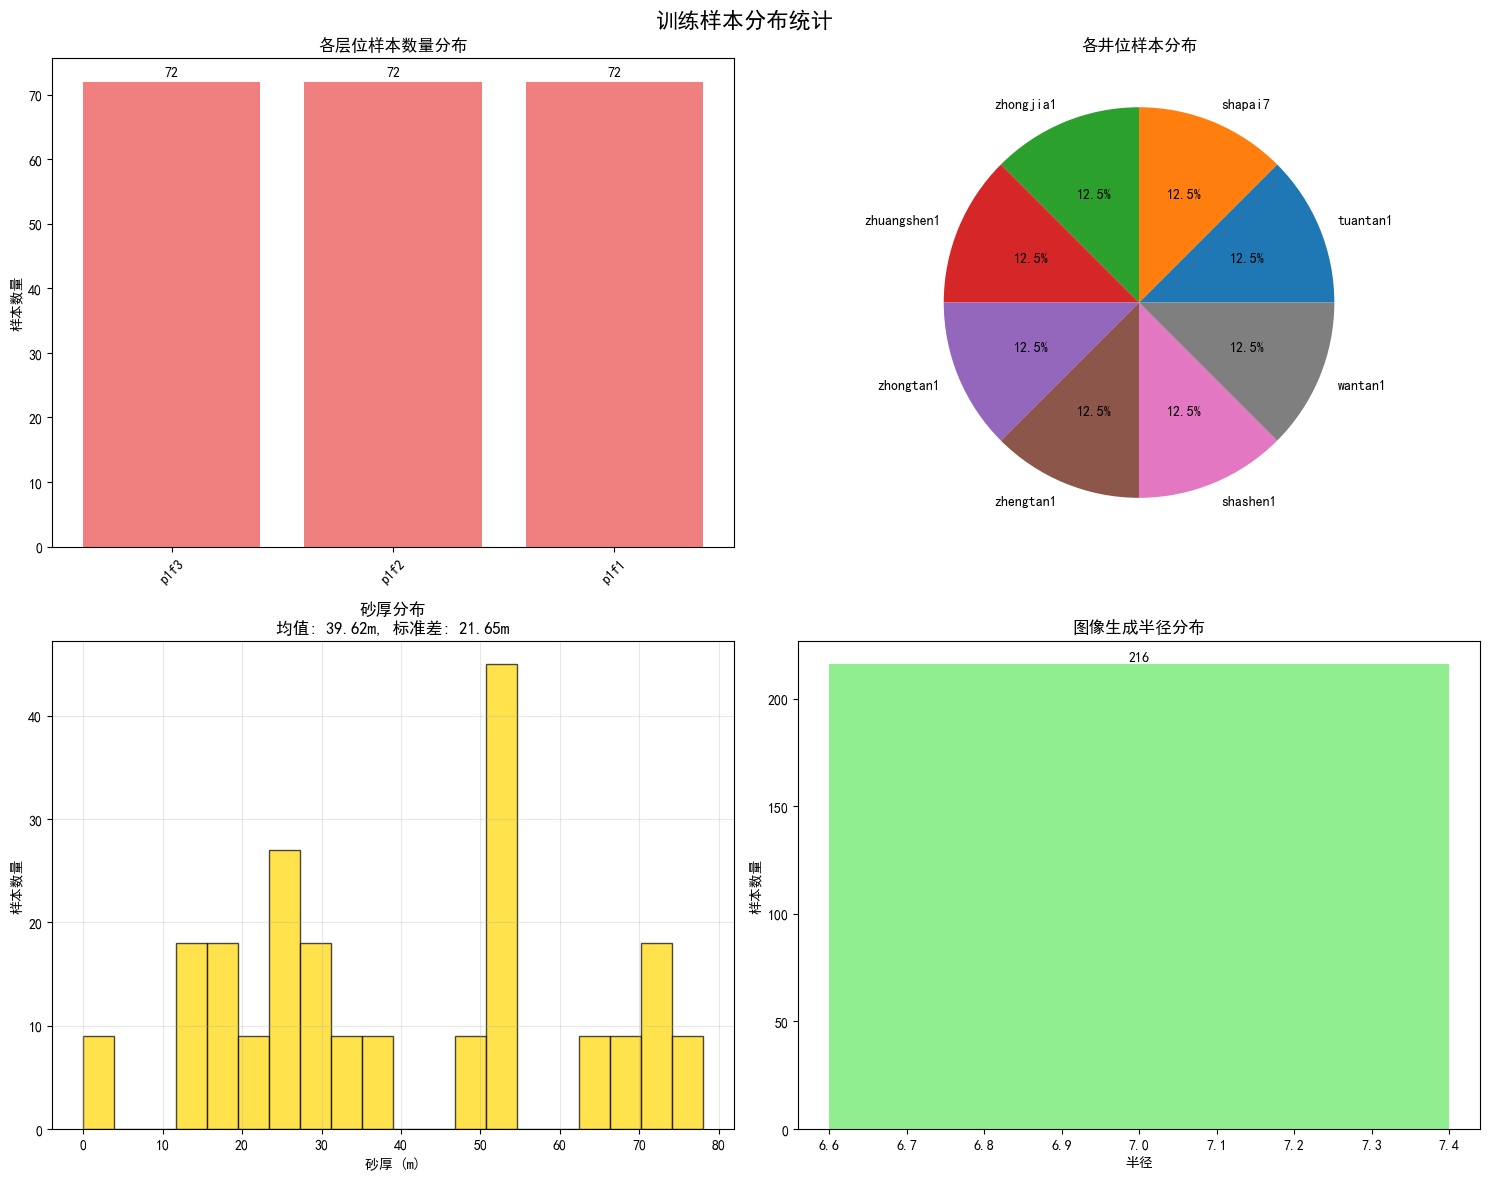


2. 生成属性统计分布...
保存图片: visualization_output/attribute_statistics.png


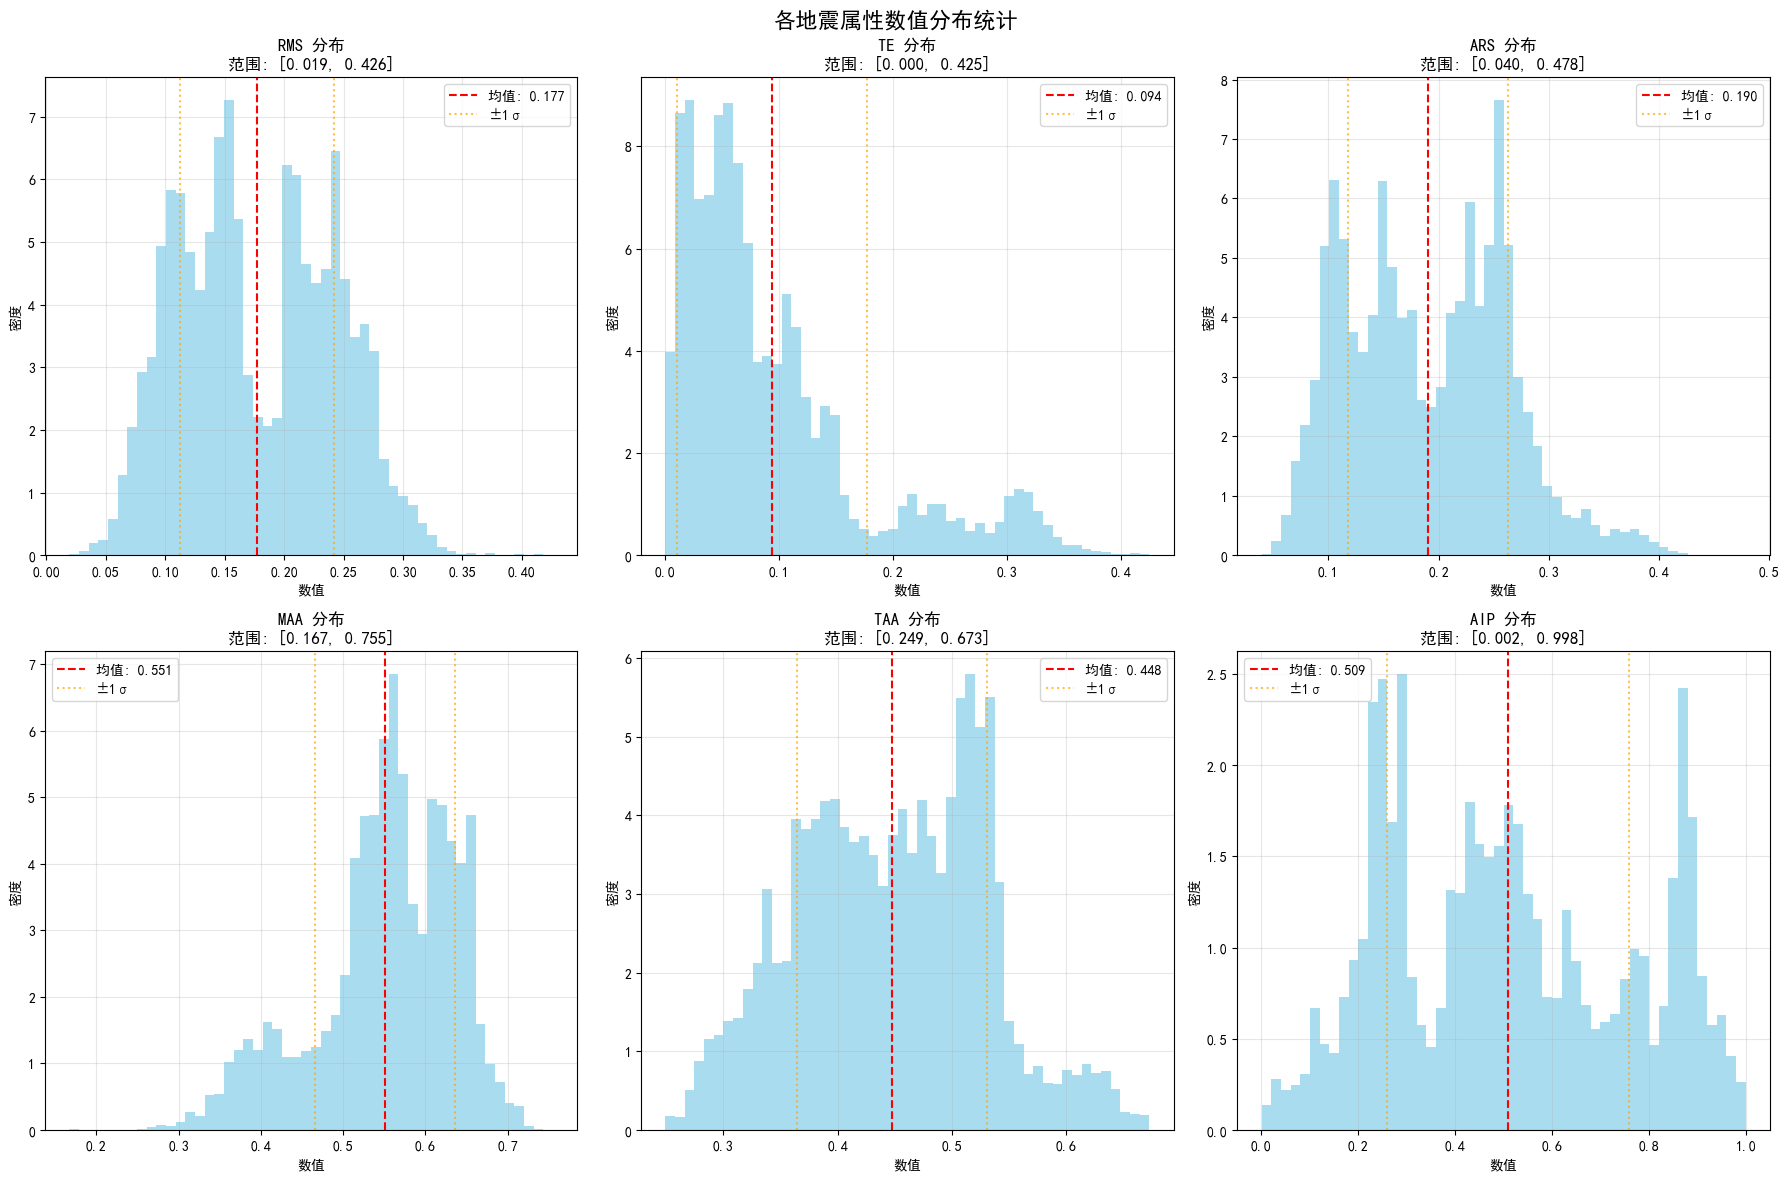


3. 生成属性相关性分析...
保存图片: visualization_output/correlation_heatmap.png


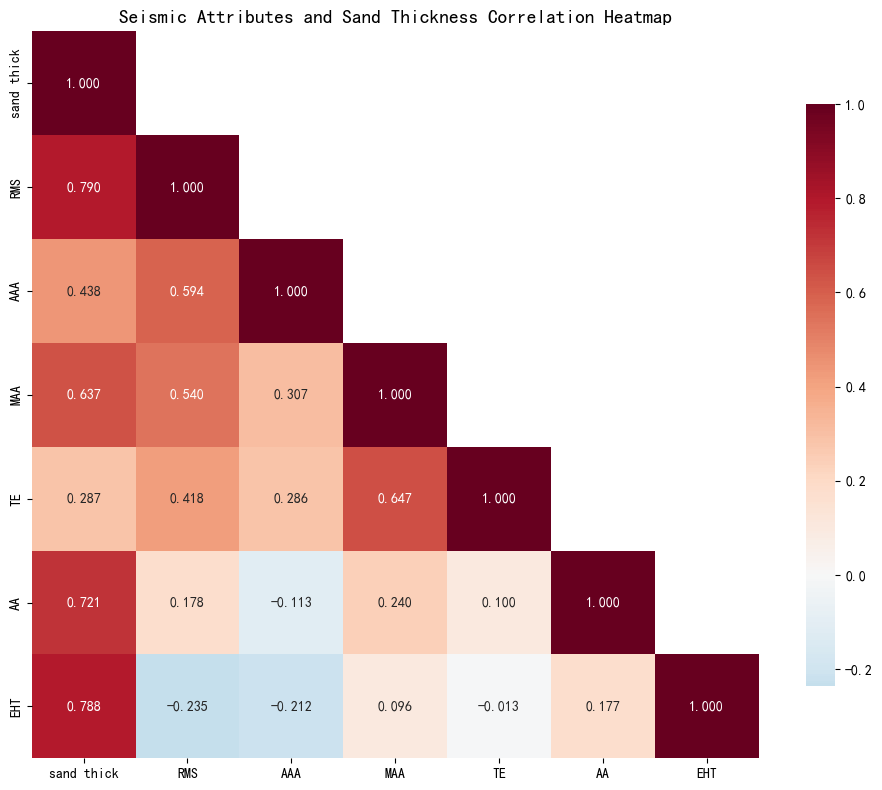


4. 生成单个样本详细展示...
保存图片: visualization_output/sample_0_tuantan1_p1f3.png


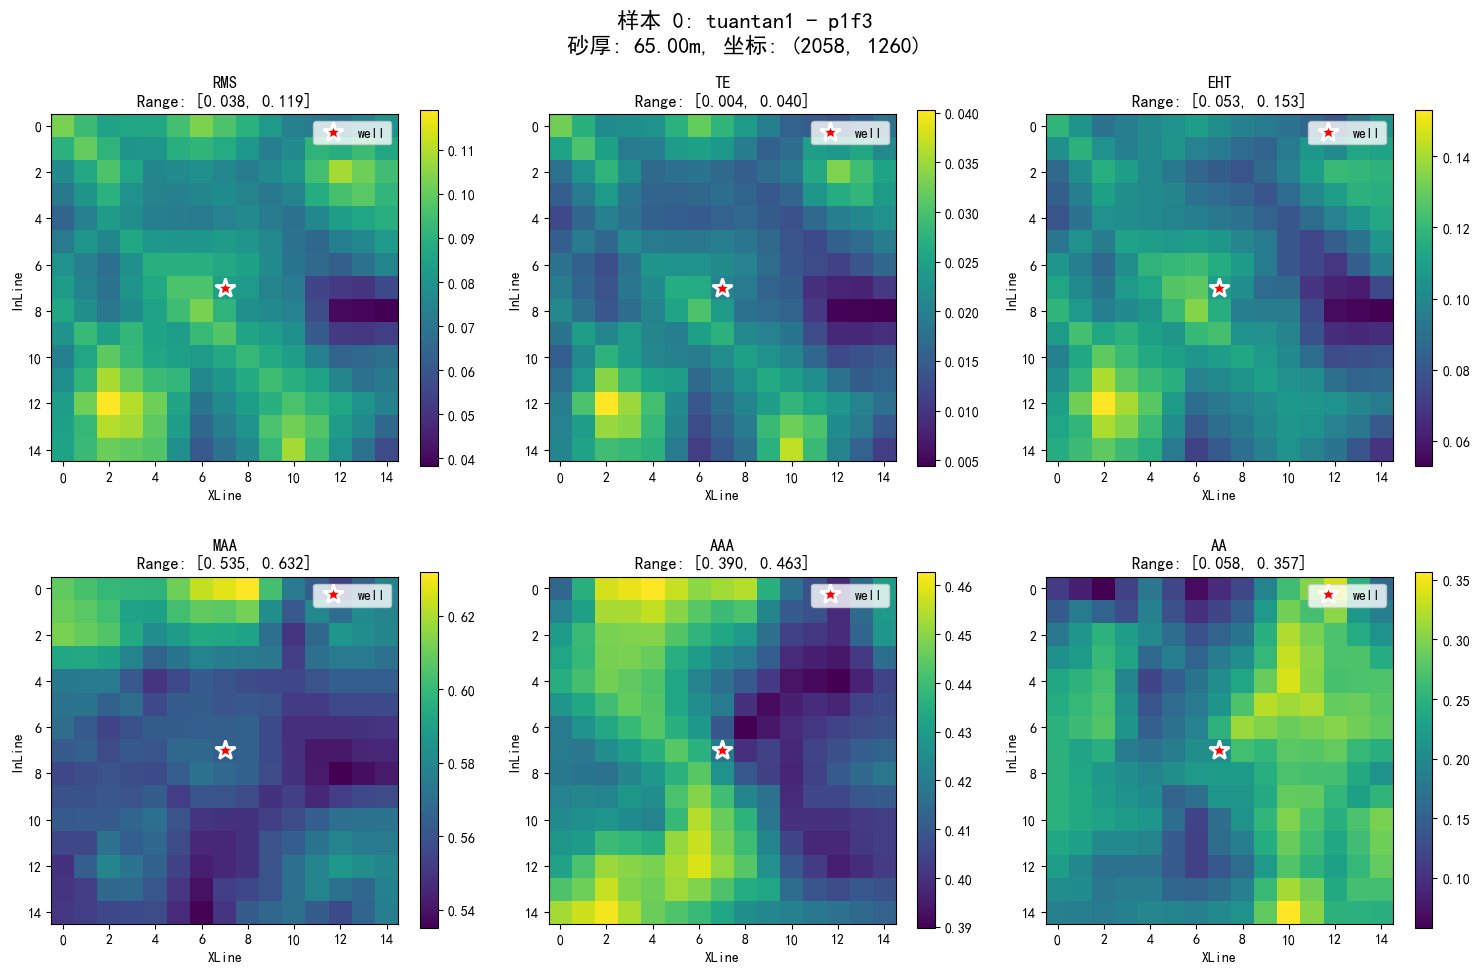


5. 生成多样本网格展示...
保存图片: visualization_output/multiple_samples_grid.png


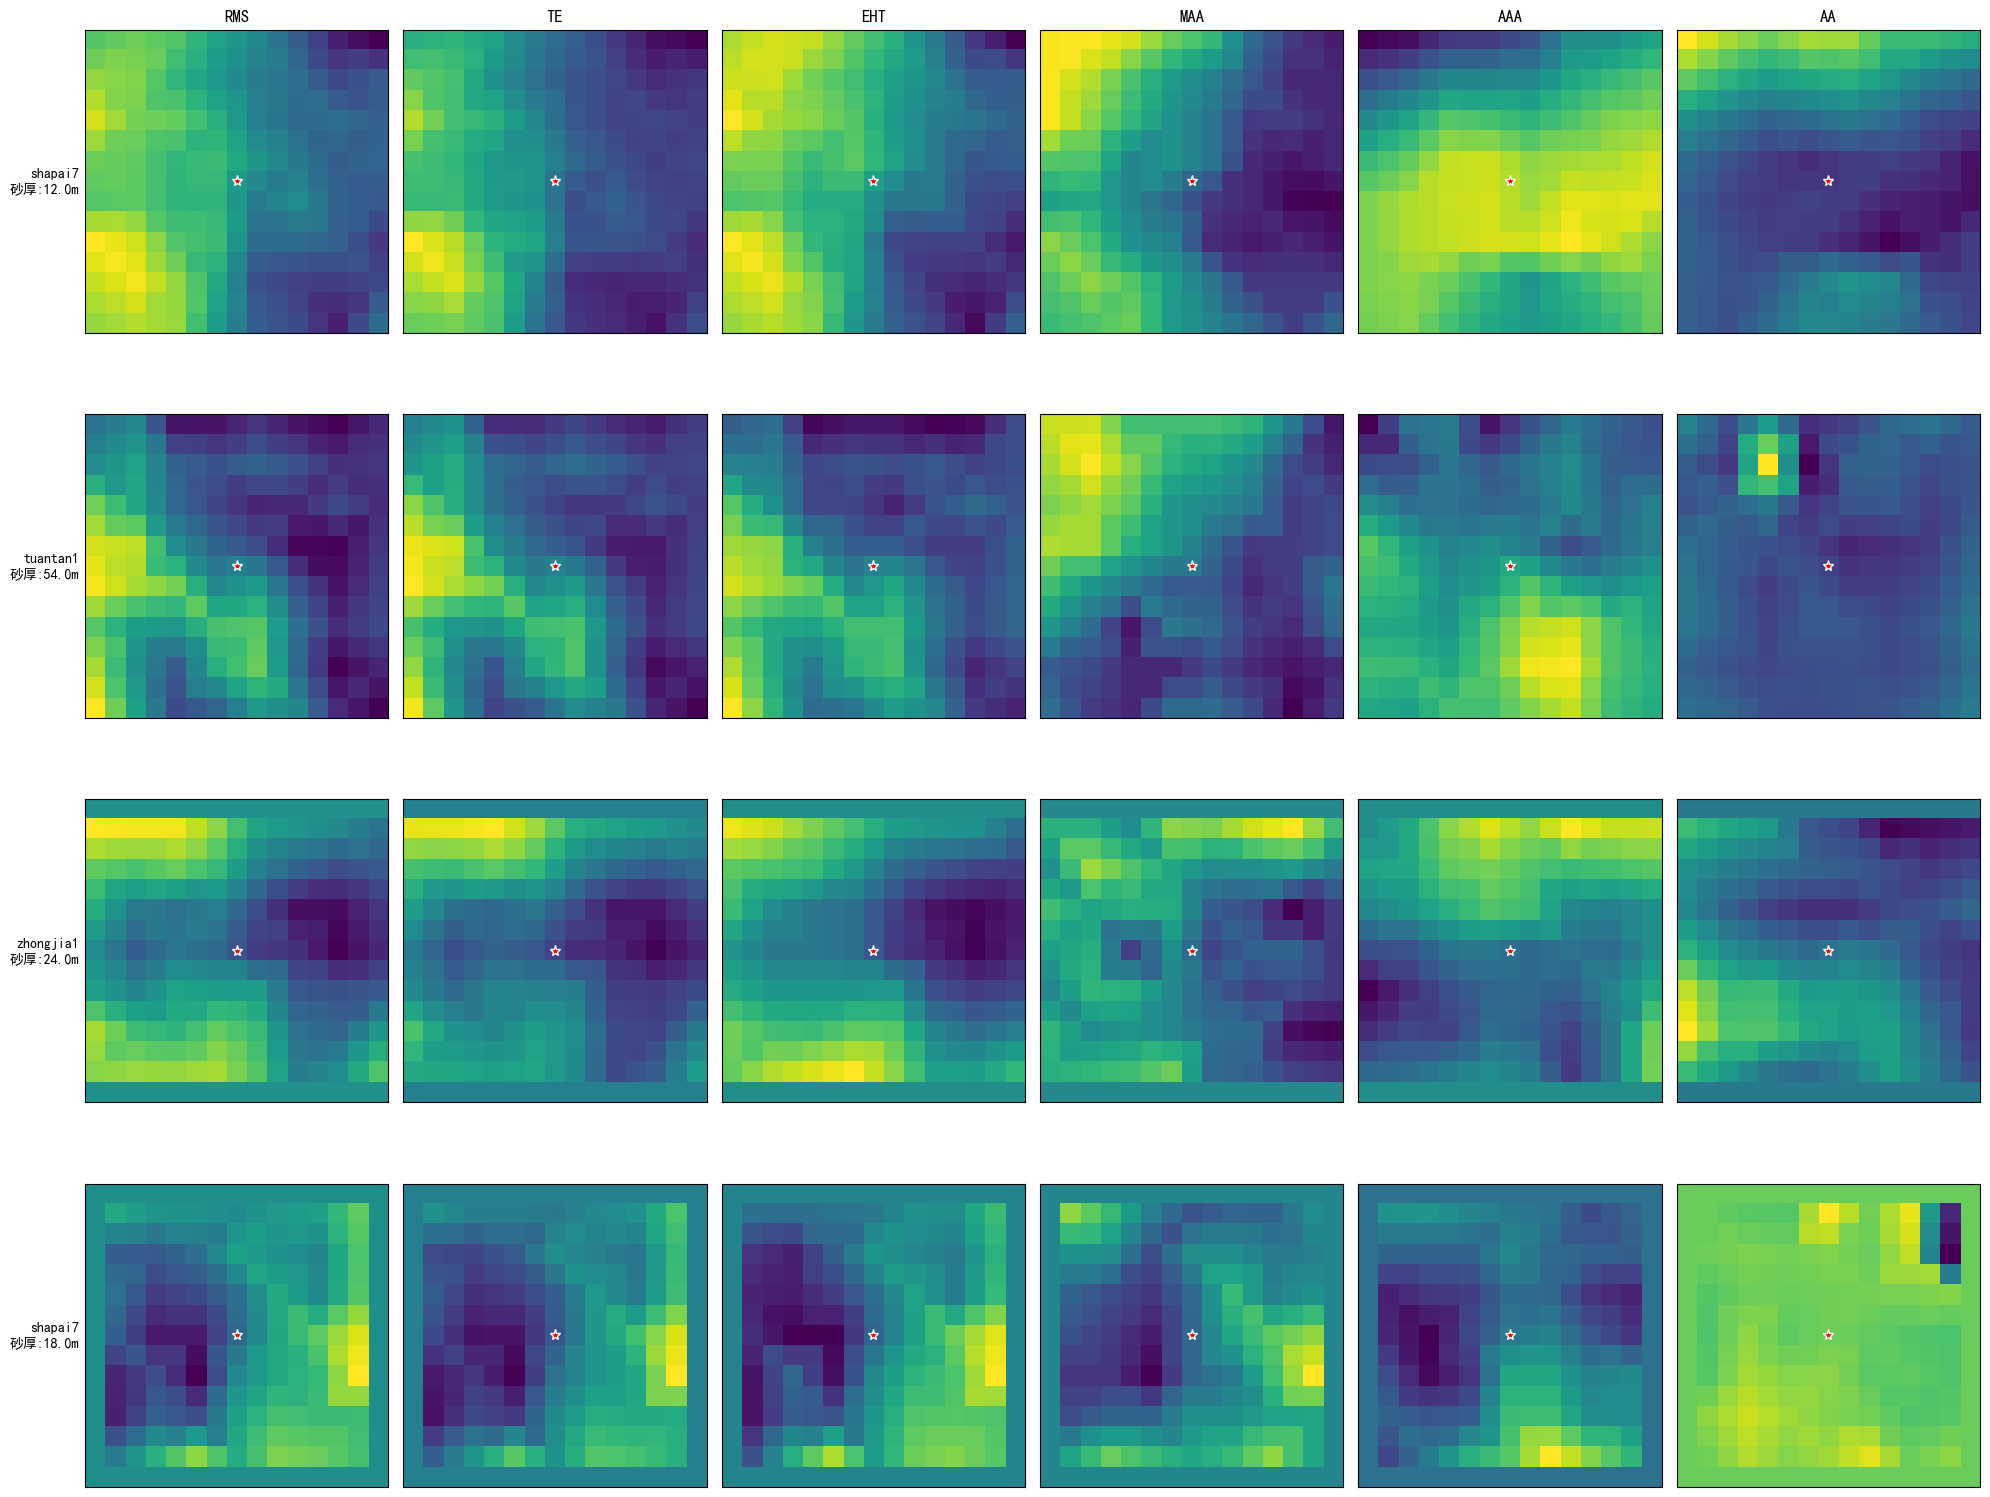


6. 生成训练/测试集划分和对比...

数据划分结果:
- 训练集: 151 个样本
- 测试集: 65 个样本
- 划分比例: 69.9% : 30.1%

6.1. 生成样本数量对比...
保存图片: visualization_output/train_test_sample_counts.png


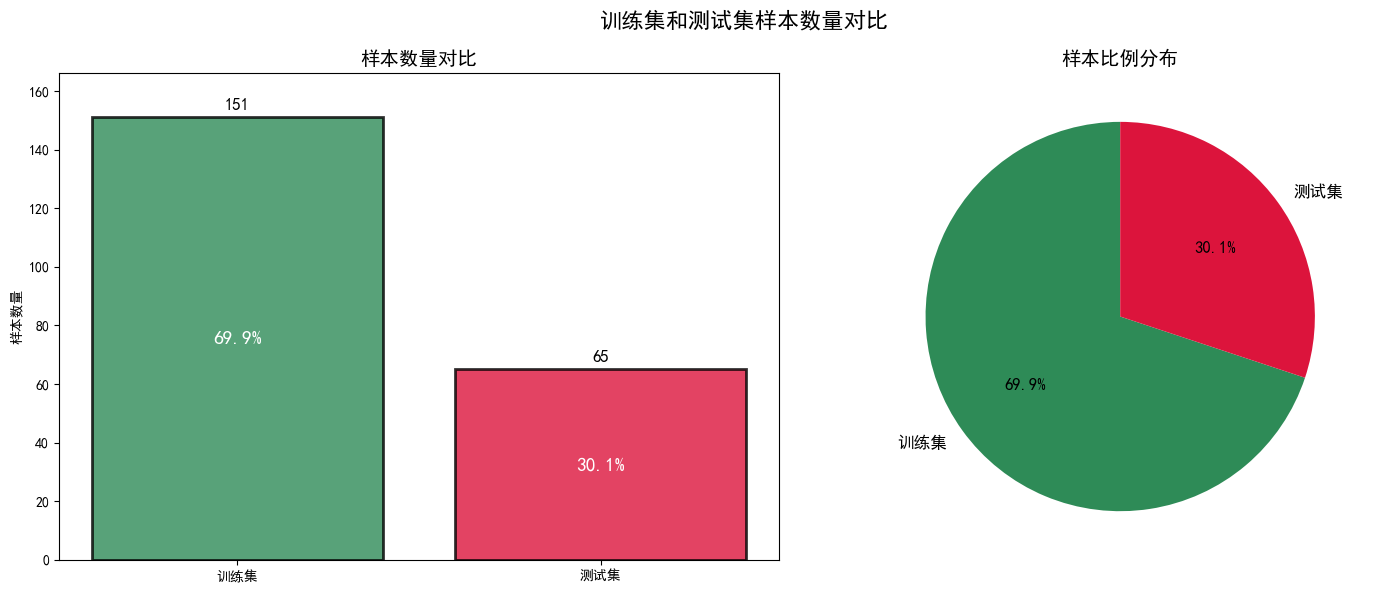


6.2. 生成层位分布对比...
保存图片: visualization_output/train_test_layer_comparison.png


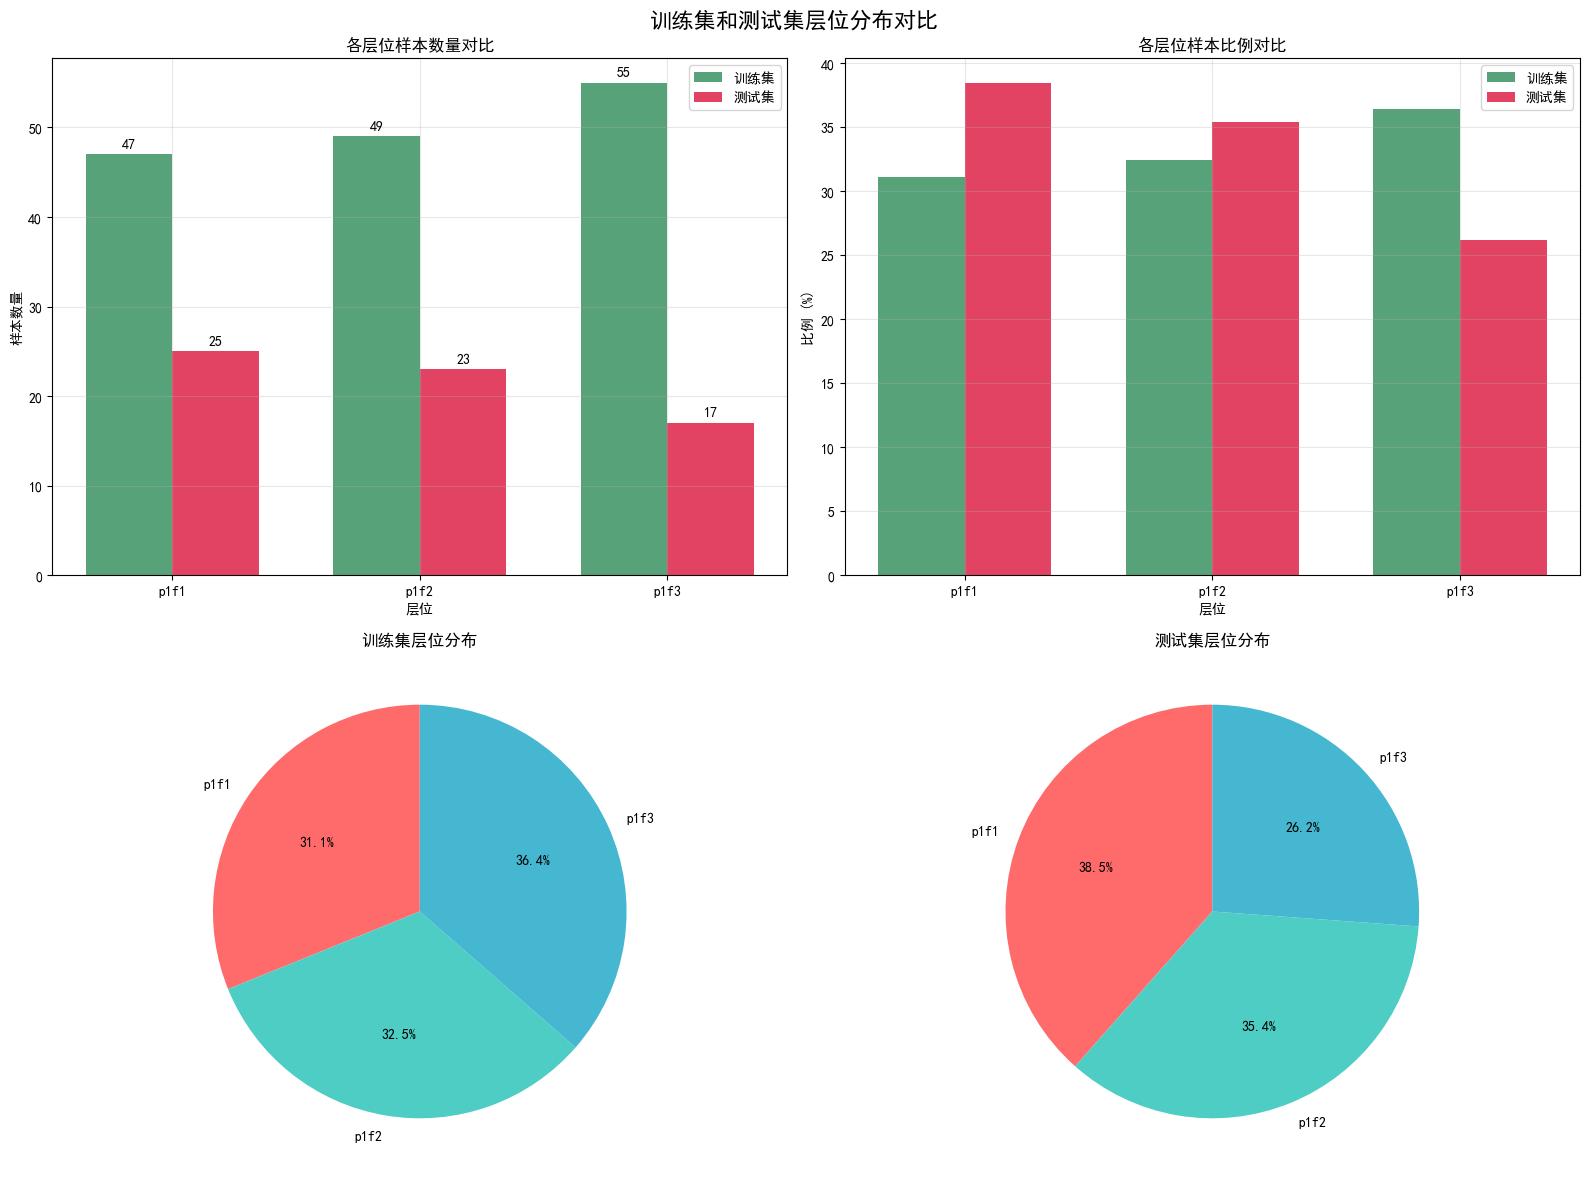


层位分布对比:
p1f1: 训练集 47个(31.1%), 测试集 25个(38.5%)
p1f2: 训练集 49个(32.5%), 测试集 23个(35.4%)
p1f3: 训练集 55个(36.4%), 测试集 17个(26.2%)

6.3. 生成井位分布对比...
保存图片: visualization_output/train_test_well_comparison.png


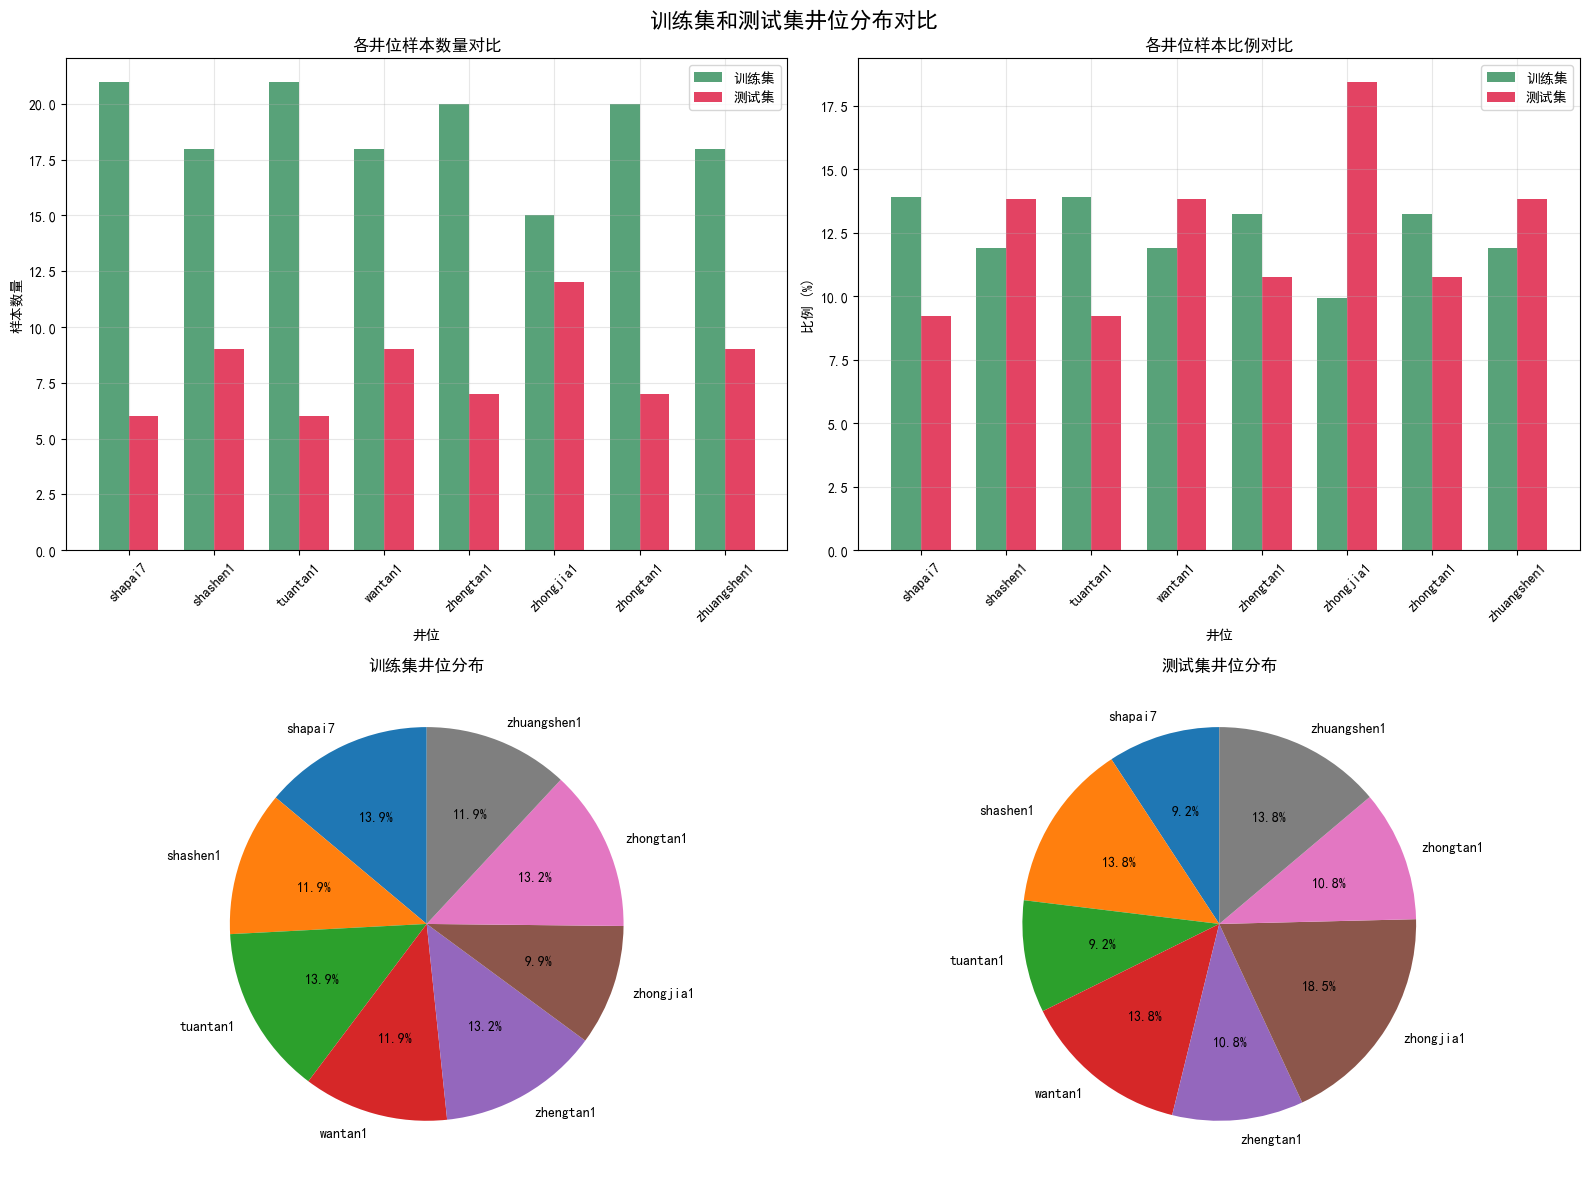


井位分布对比:
shapai7: 训练集 21个(13.9%), 测试集 6个(9.2%)
shashen1: 训练集 18个(11.9%), 测试集 9个(13.8%)
tuantan1: 训练集 21个(13.9%), 测试集 6个(9.2%)
wantan1: 训练集 18个(11.9%), 测试集 9个(13.8%)
zhengtan1: 训练集 20个(13.2%), 测试集 7个(10.8%)
zhongjia1: 训练集 15个(9.9%), 测试集 12个(18.5%)
zhongtan1: 训练集 20个(13.2%), 测试集 7个(10.8%)
zhuangshen1: 训练集 18个(11.9%), 测试集 9个(13.8%)

7. 生成完整数据集多样本网格展示...
开始生成完整数据集网格展示...
井位数量: 8
层位顺序: ['p1f1', 'p1f2', 'p1f3']
总样本数: 216

正在处理井位 1/8: shapai7
  处理层位 p1f1: 砂厚 18.00m
  处理层位 p1f2: 砂厚 14.00m
  处理层位 p1f3: 砂厚 12.00m
  保存图片: visualization_output/well_shapai7_complete_grid.png


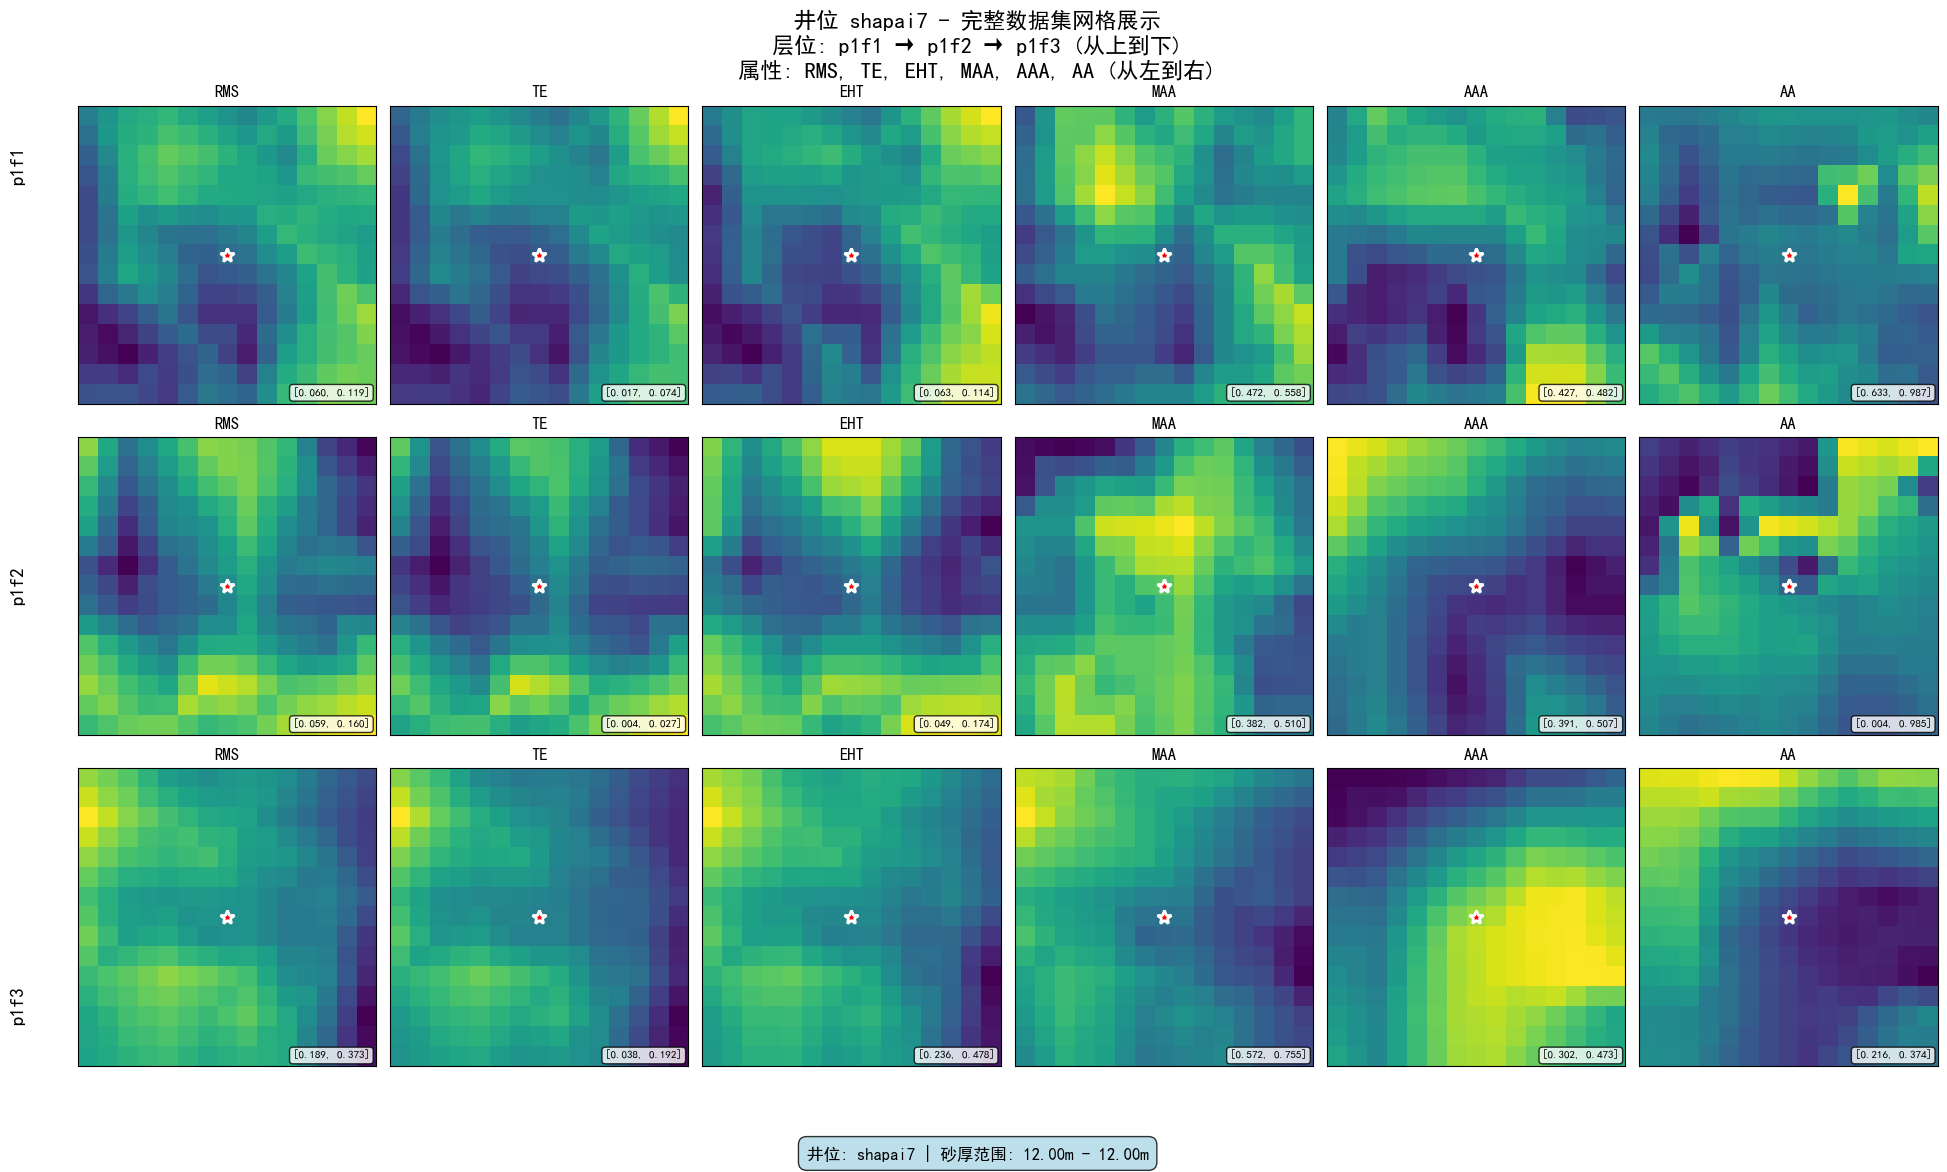


正在处理井位 2/8: shashen1
  处理层位 p1f1: 砂厚 52.00m
  处理层位 p1f2: 砂厚 72.00m
  处理层位 p1f3: 砂厚 52.00m
  保存图片: visualization_output/well_shashen1_complete_grid.png


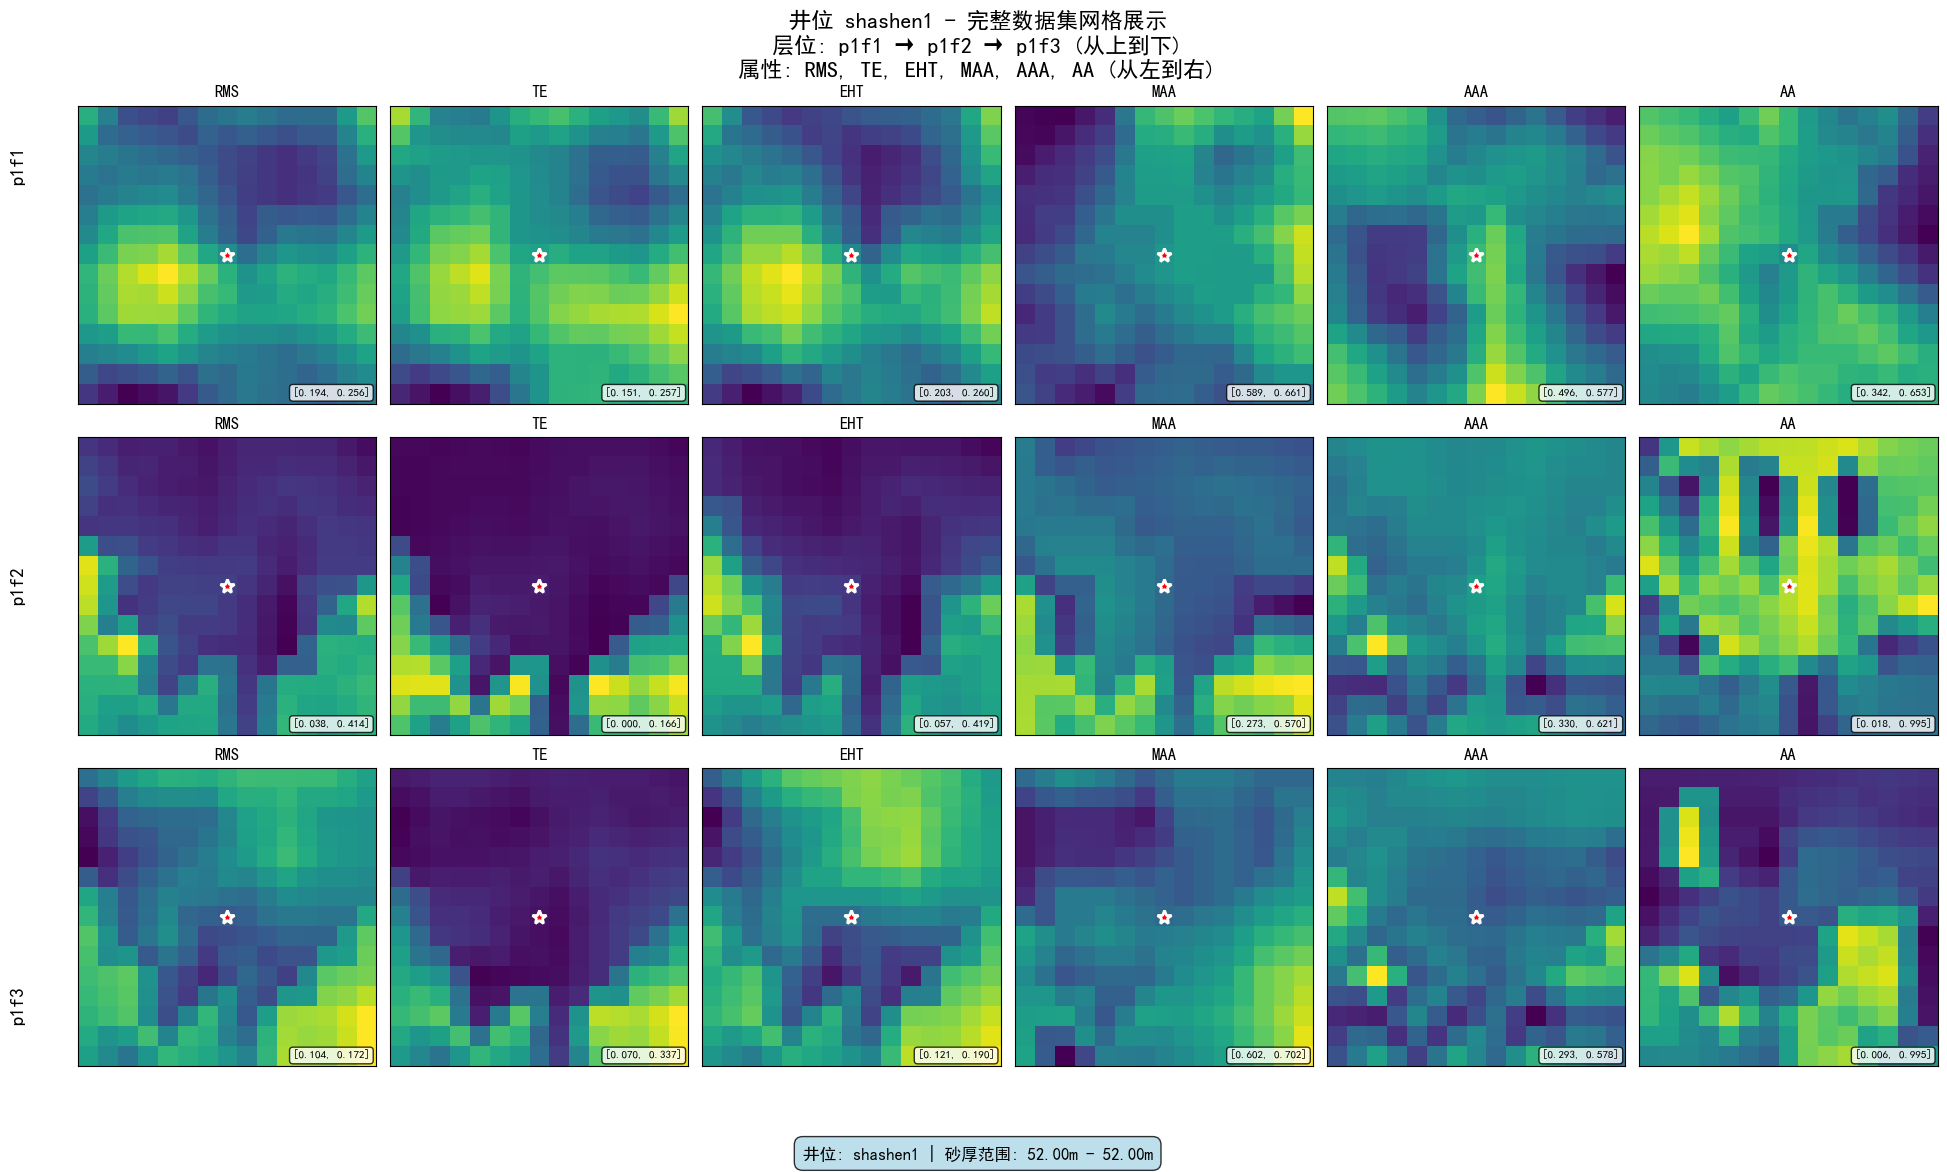


正在处理井位 3/8: tuantan1
  处理层位 p1f1: 砂厚 54.00m
  处理层位 p1f2: 砂厚 34.00m
  处理层位 p1f3: 砂厚 65.00m
  保存图片: visualization_output/well_tuantan1_complete_grid.png


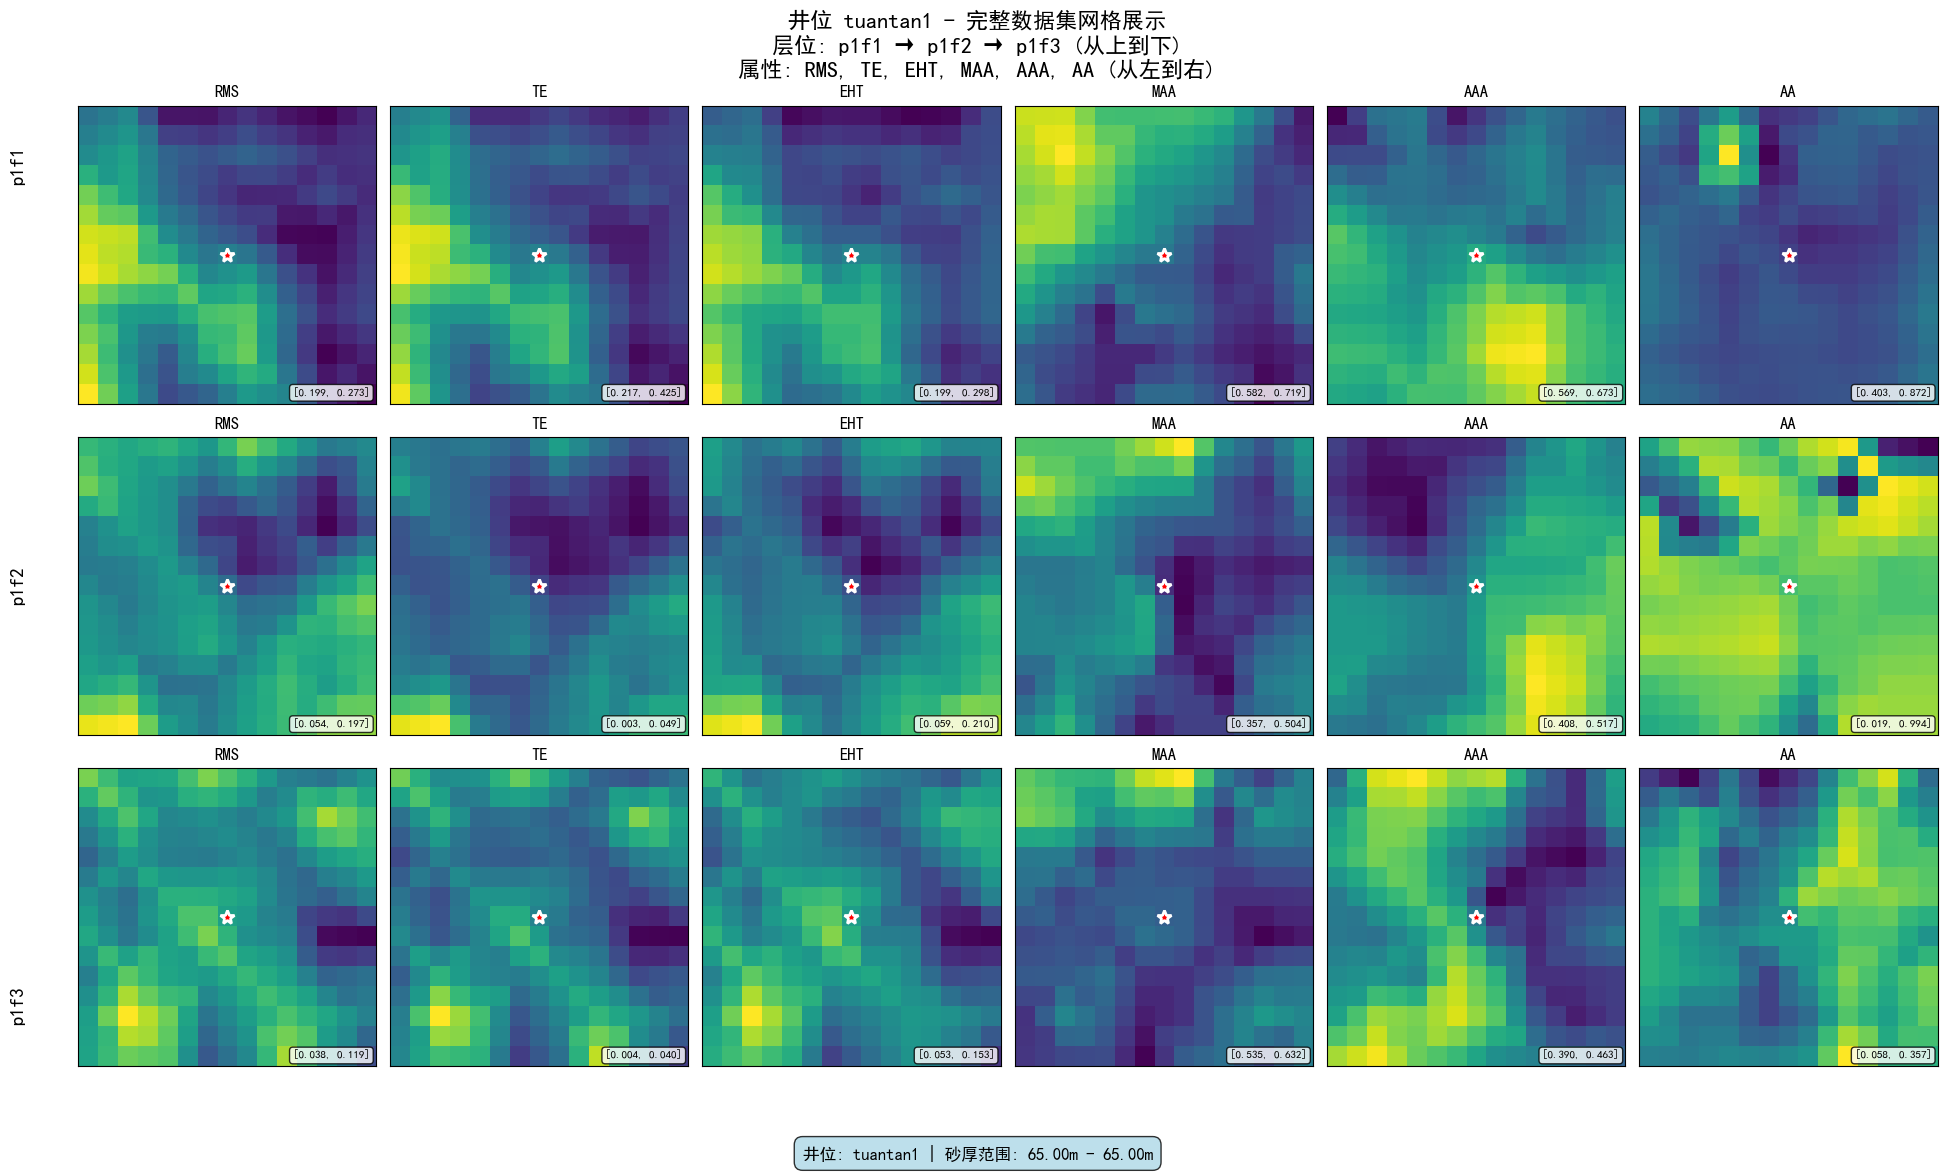


正在处理井位 4/8: wantan1
  处理层位 p1f1: 砂厚 27.00m
  处理层位 p1f2: 砂厚 25.00m
  处理层位 p1f3: 砂厚 21.00m
  保存图片: visualization_output/well_wantan1_complete_grid.png


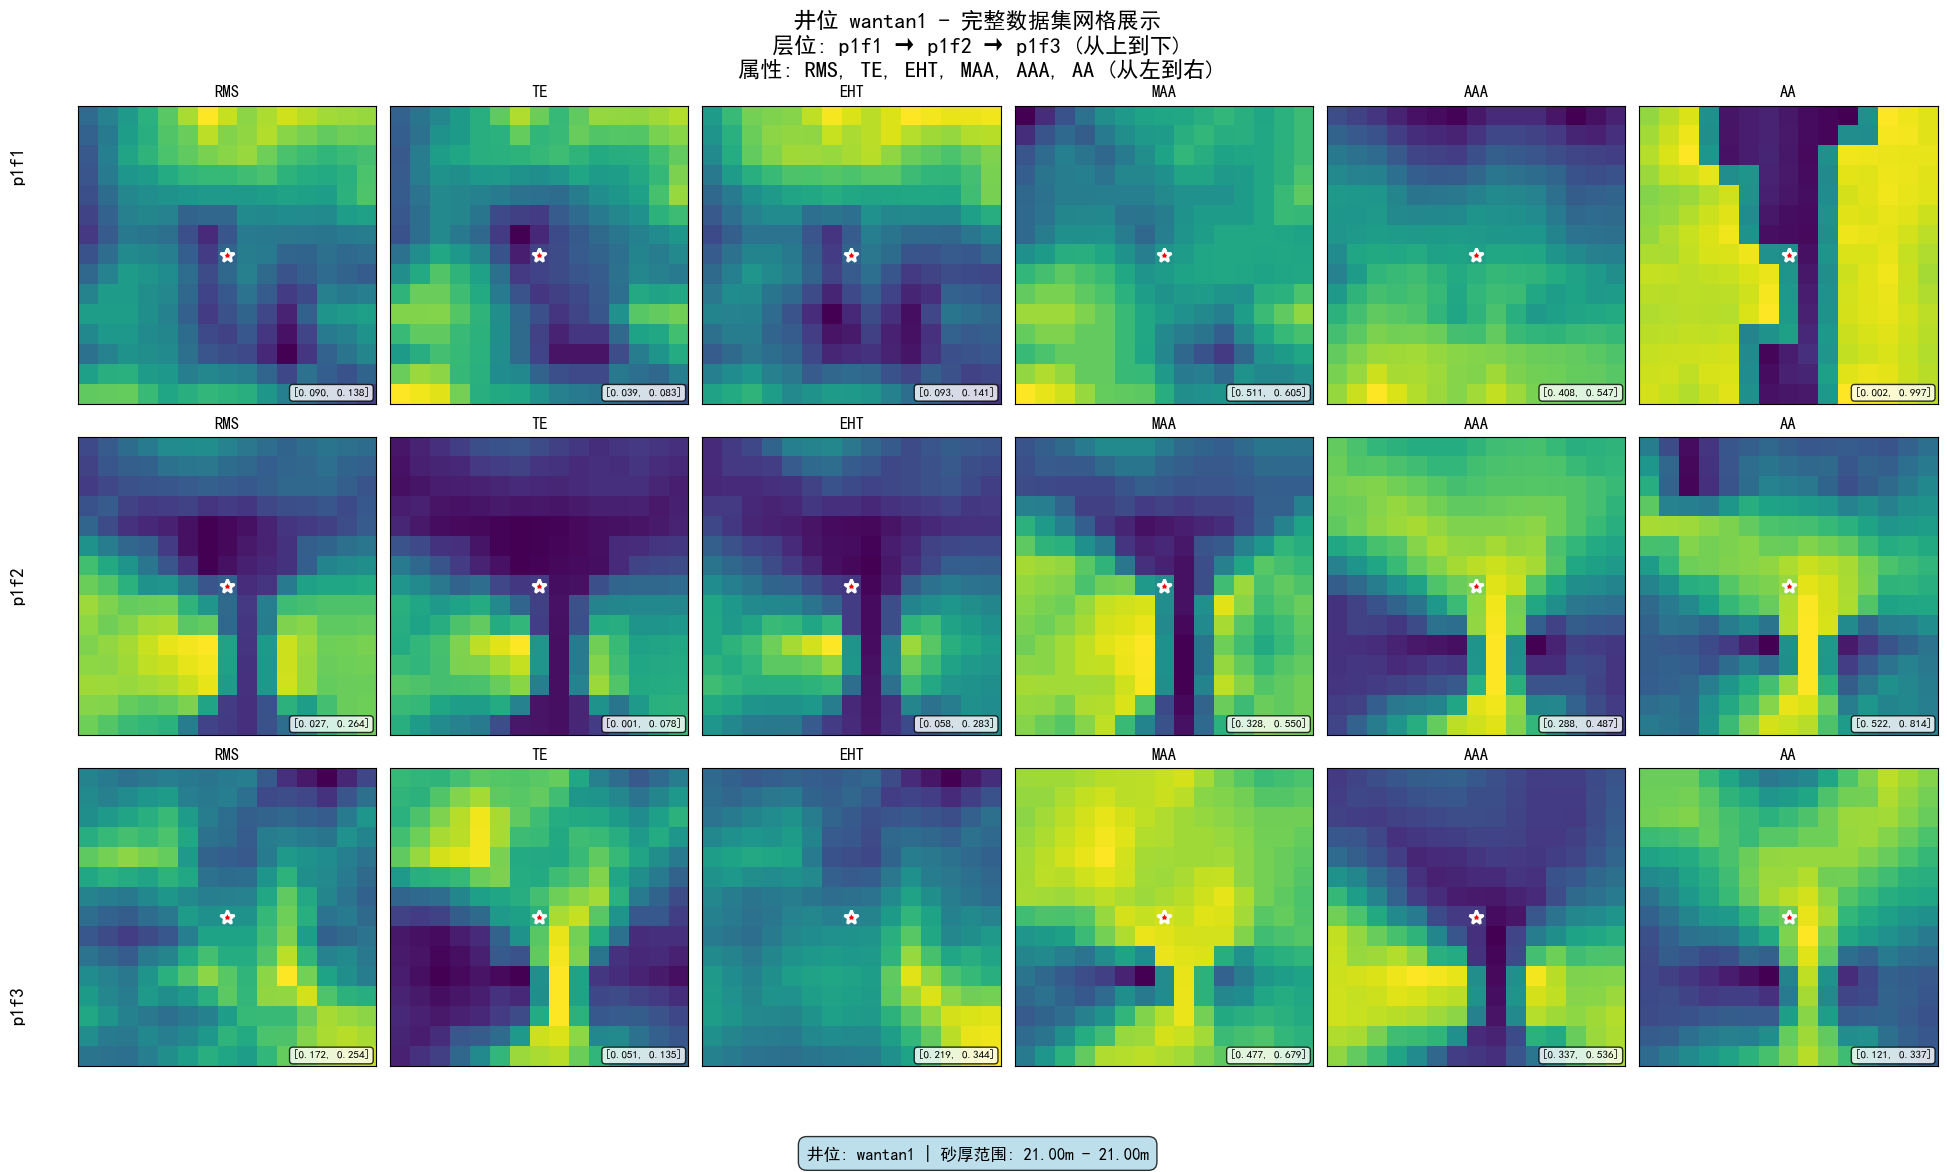


正在处理井位 5/8: zhengtan1
  处理层位 p1f1: 砂厚 0.00m
  处理层位 p1f2: 砂厚 53.00m
  处理层位 p1f3: 砂厚 29.00m
  保存图片: visualization_output/well_zhengtan1_complete_grid.png


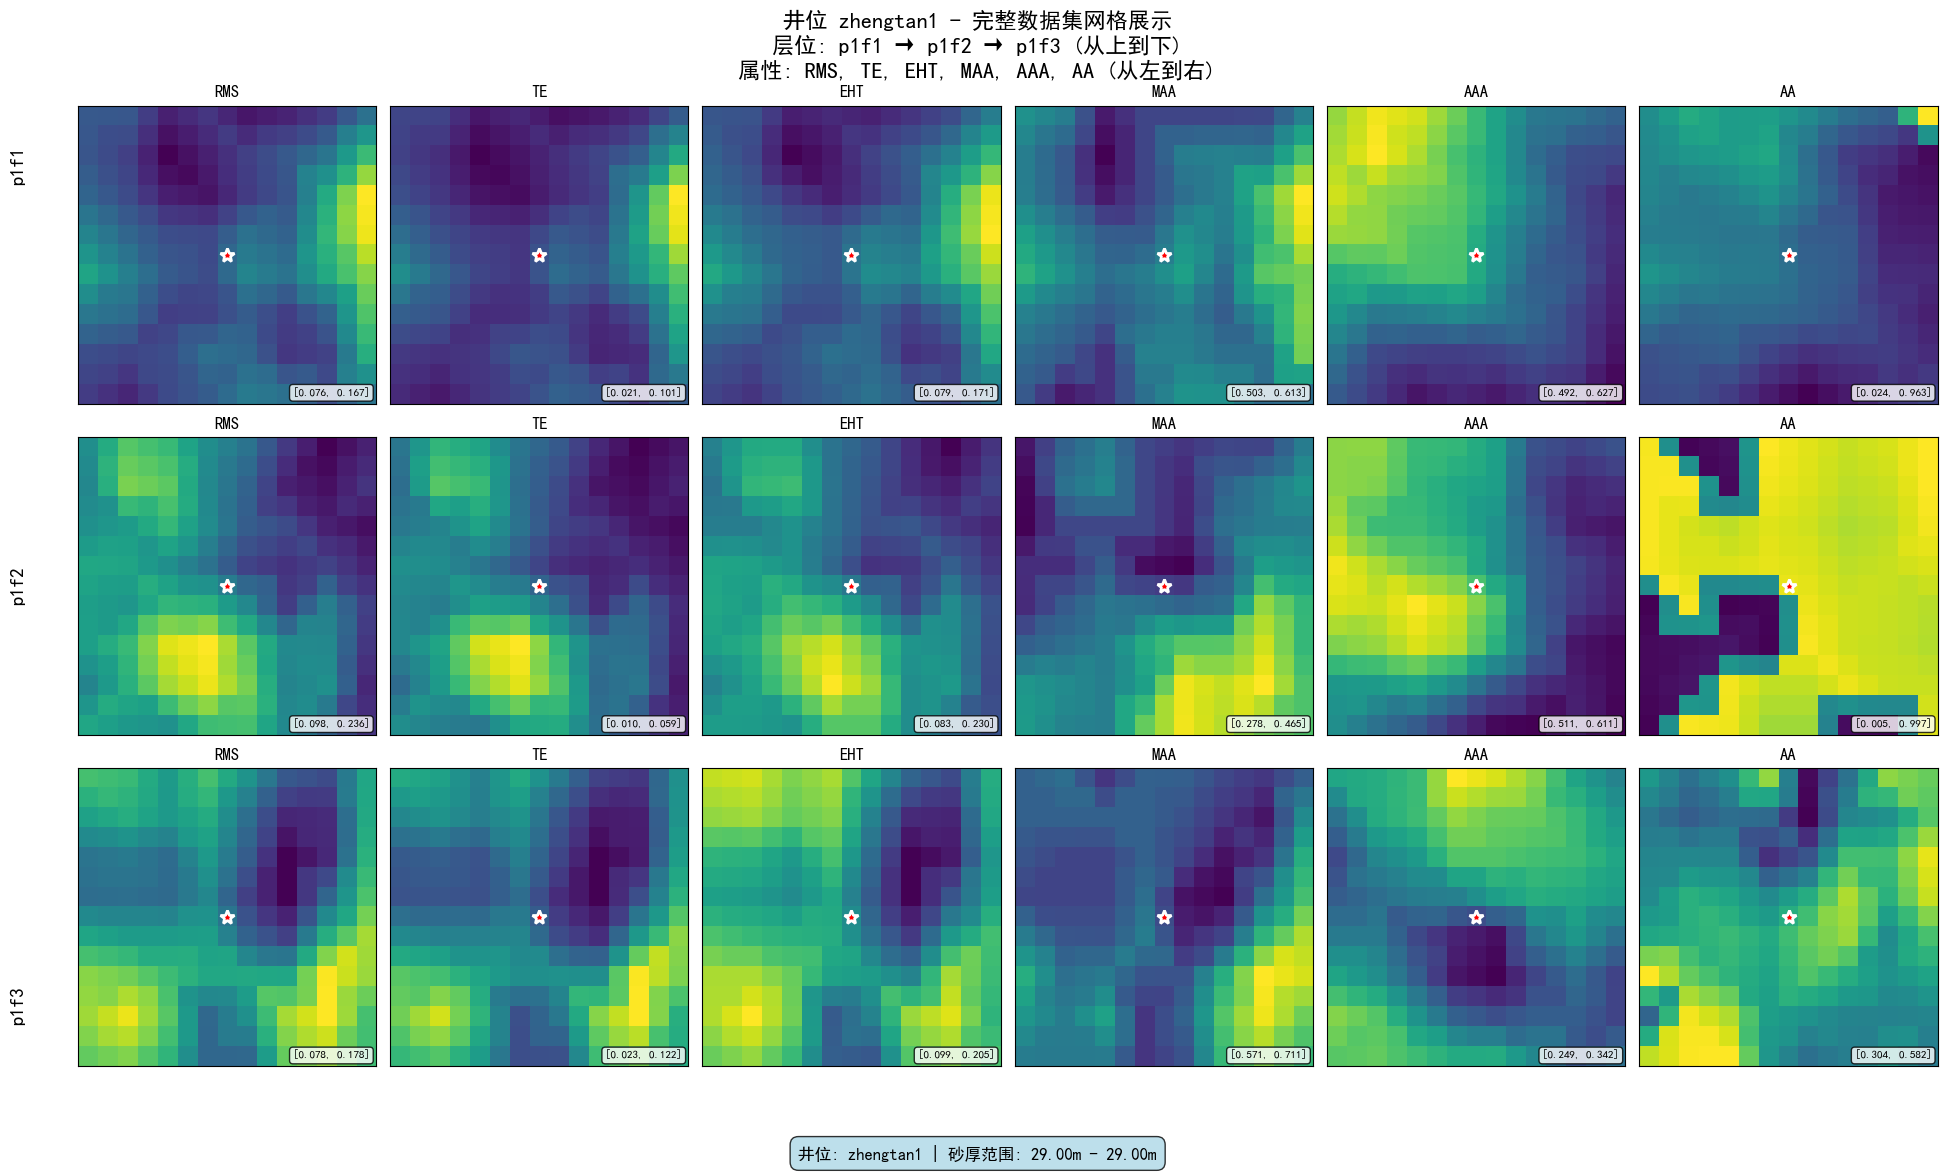


正在处理井位 6/8: zhongjia1
  处理层位 p1f1: 砂厚 28.00m
  处理层位 p1f2: 砂厚 16.00m
  处理层位 p1f3: 砂厚 24.00m
  保存图片: visualization_output/well_zhongjia1_complete_grid.png


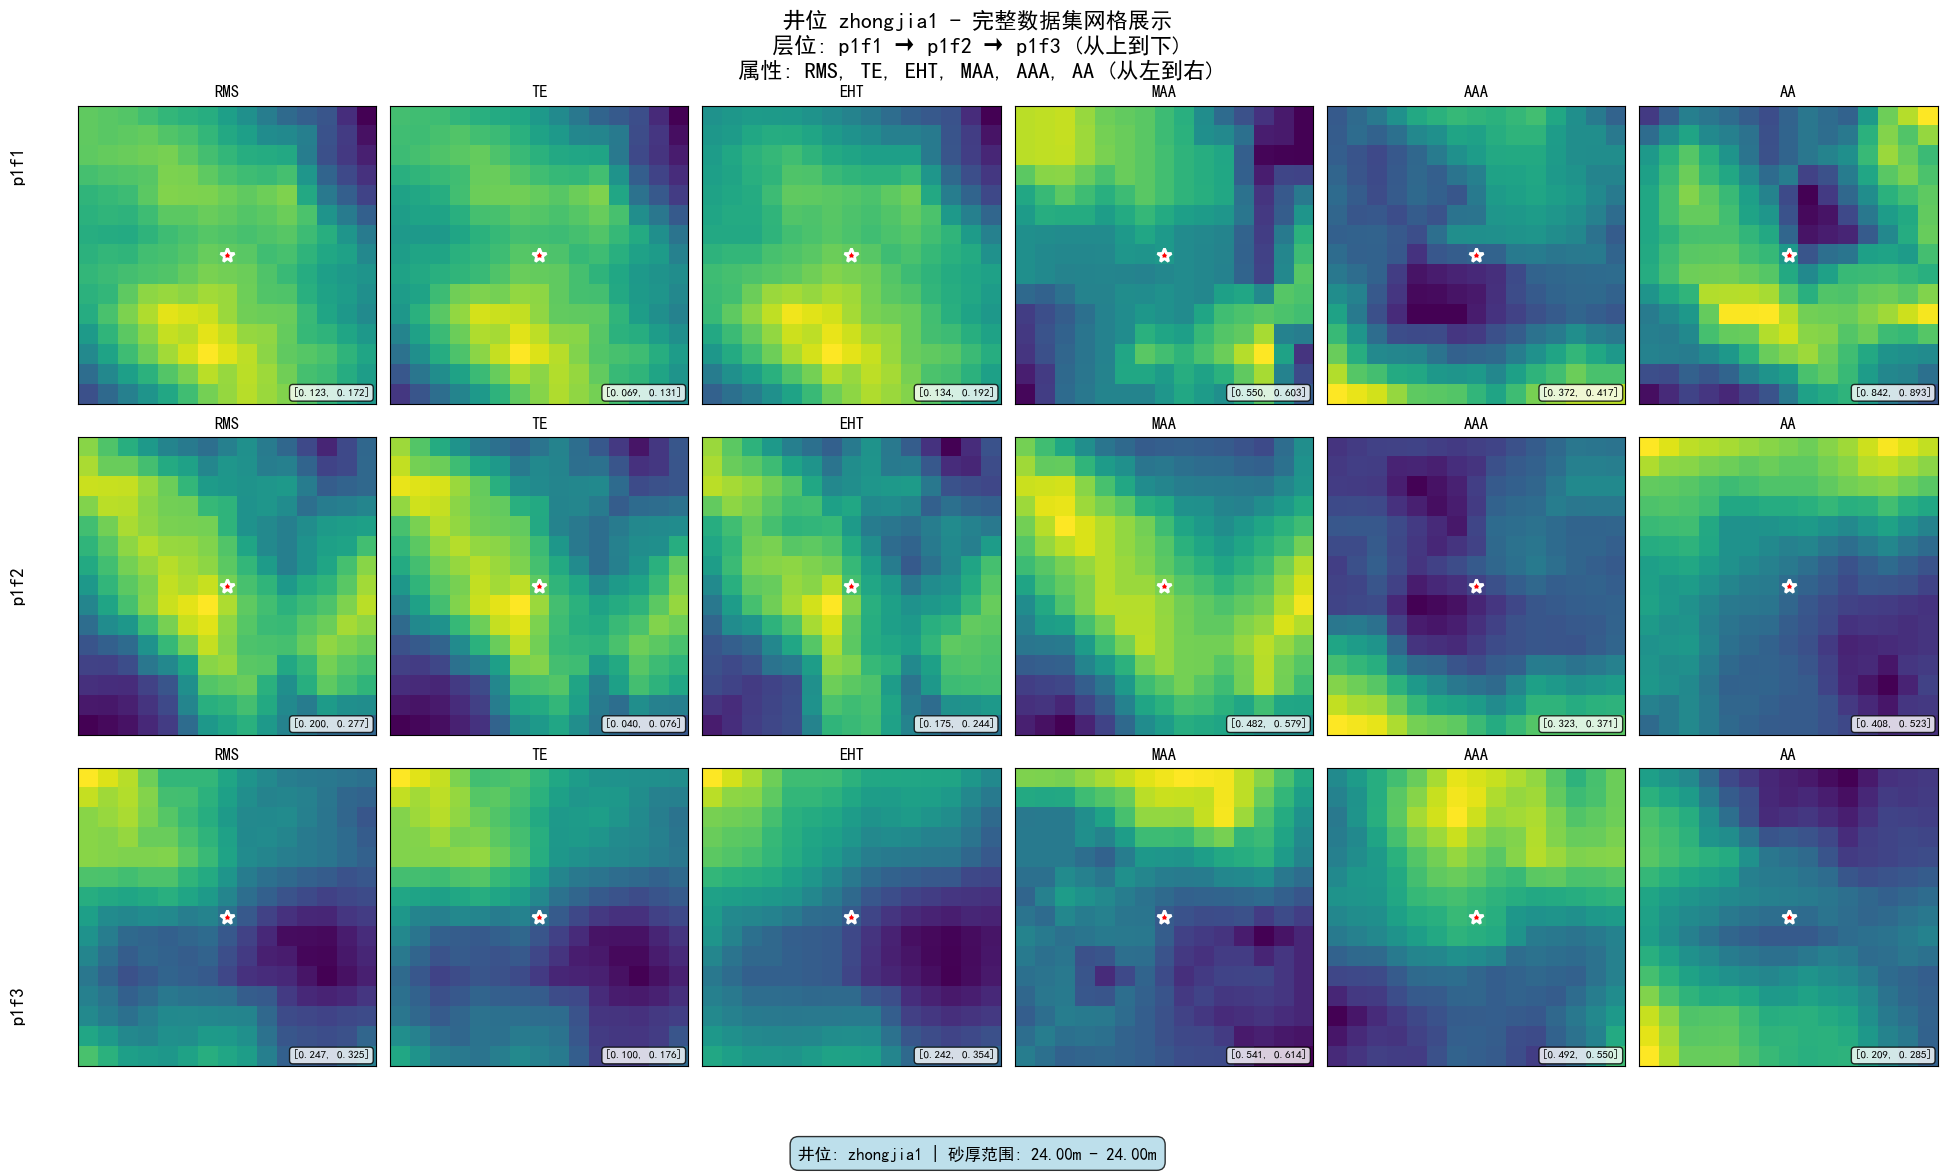


正在处理井位 7/8: zhongtan1
  处理层位 p1f1: 砂厚 48.00m
  处理层位 p1f2: 砂厚 52.00m
  处理层位 p1f3: 砂厚 68.00m
  保存图片: visualization_output/well_zhongtan1_complete_grid.png


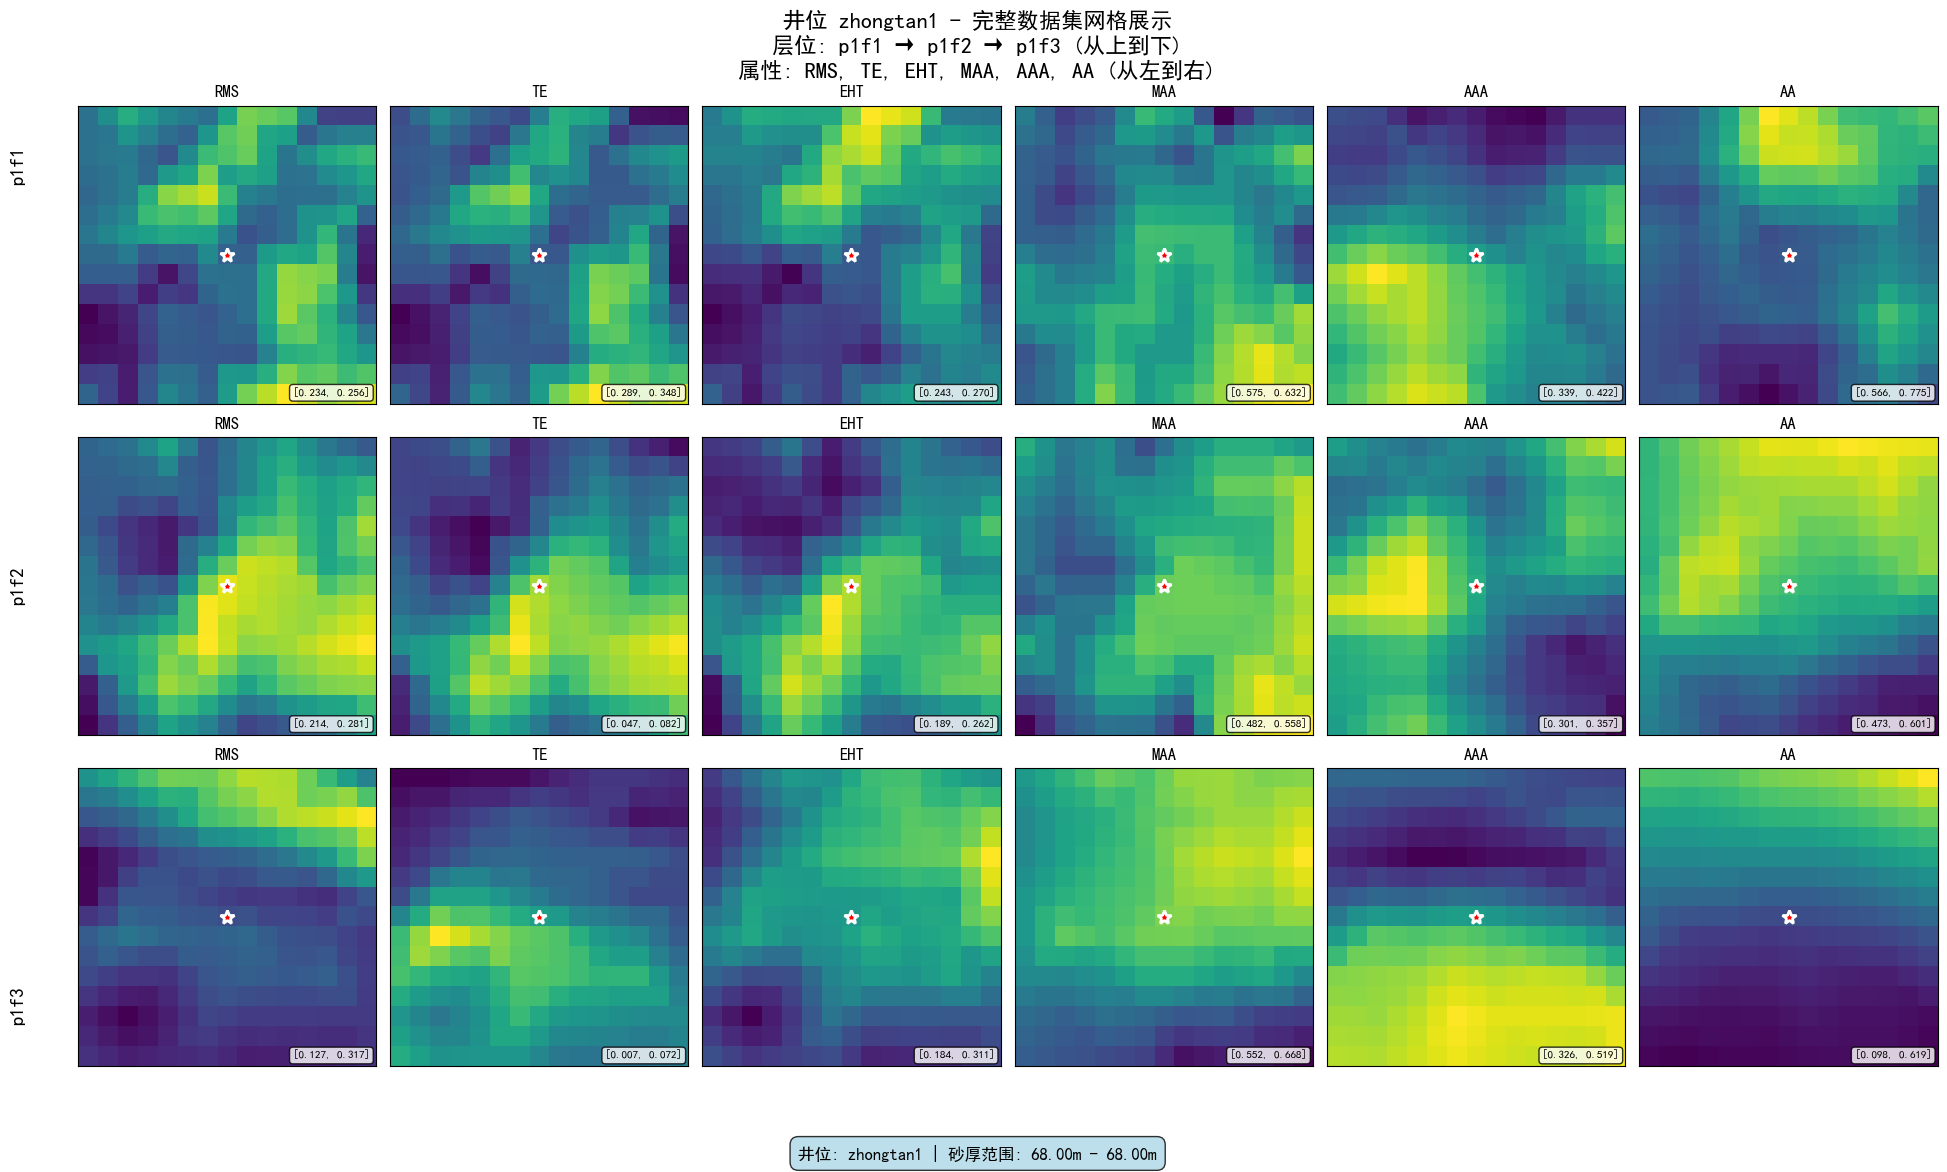


正在处理井位 8/8: zhuangshen1
  处理层位 p1f1: 砂厚 72.00m
  处理层位 p1f2: 砂厚 78.00m
  处理层位 p1f3: 砂厚 37.00m
  保存图片: visualization_output/well_zhuangshen1_complete_grid.png


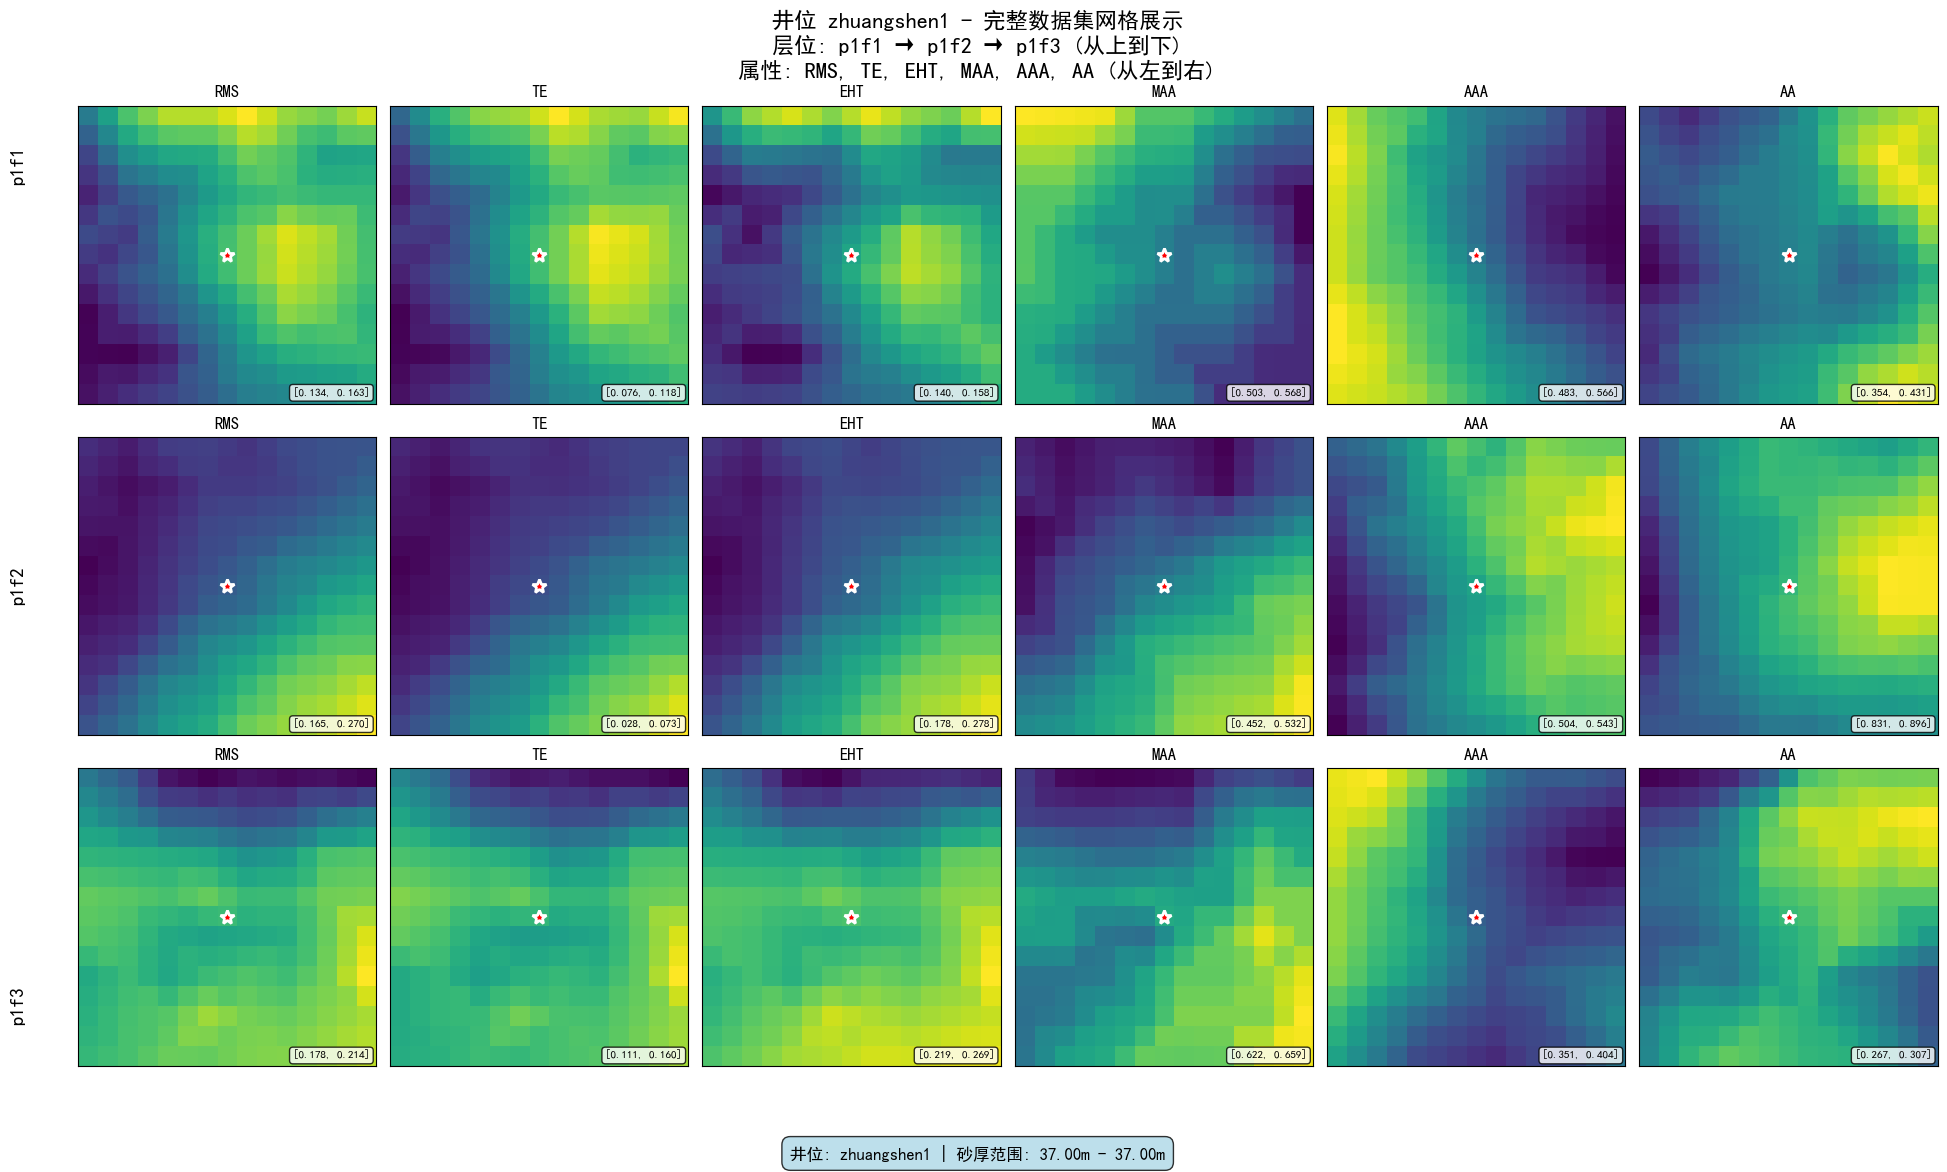


完成! 共生成 8 张井位网格展示图片
每张图片包含: 3个层位 × 6个属性 = 18个子图
层位顺序: p1f1 (上) → p1f2 (中) → p1f3 (下)
属性顺序: RMS, TE, EHT, MAA, AAA, AA (左到右)

所有可视化结果已保存至: visualization_output/
可视化报告生成完成!
成功加载 216 个样本
图像形状: (15, 15, 6)
数据加载成功，开始生成按井分类的完整数据集网格展示...
开始生成完整数据集网格展示...
井位数量: 8
层位顺序: ['p1f1', 'p1f2', 'p1f3']
总样本数: 216

正在处理井位 1/8: shapai7
  处理层位 p1f1: 砂厚 18.00m
  处理层位 p1f2: 砂厚 14.00m
  处理层位 p1f3: 砂厚 12.00m
  保存图片: visualization_output/well_shapai7_complete_grid.png


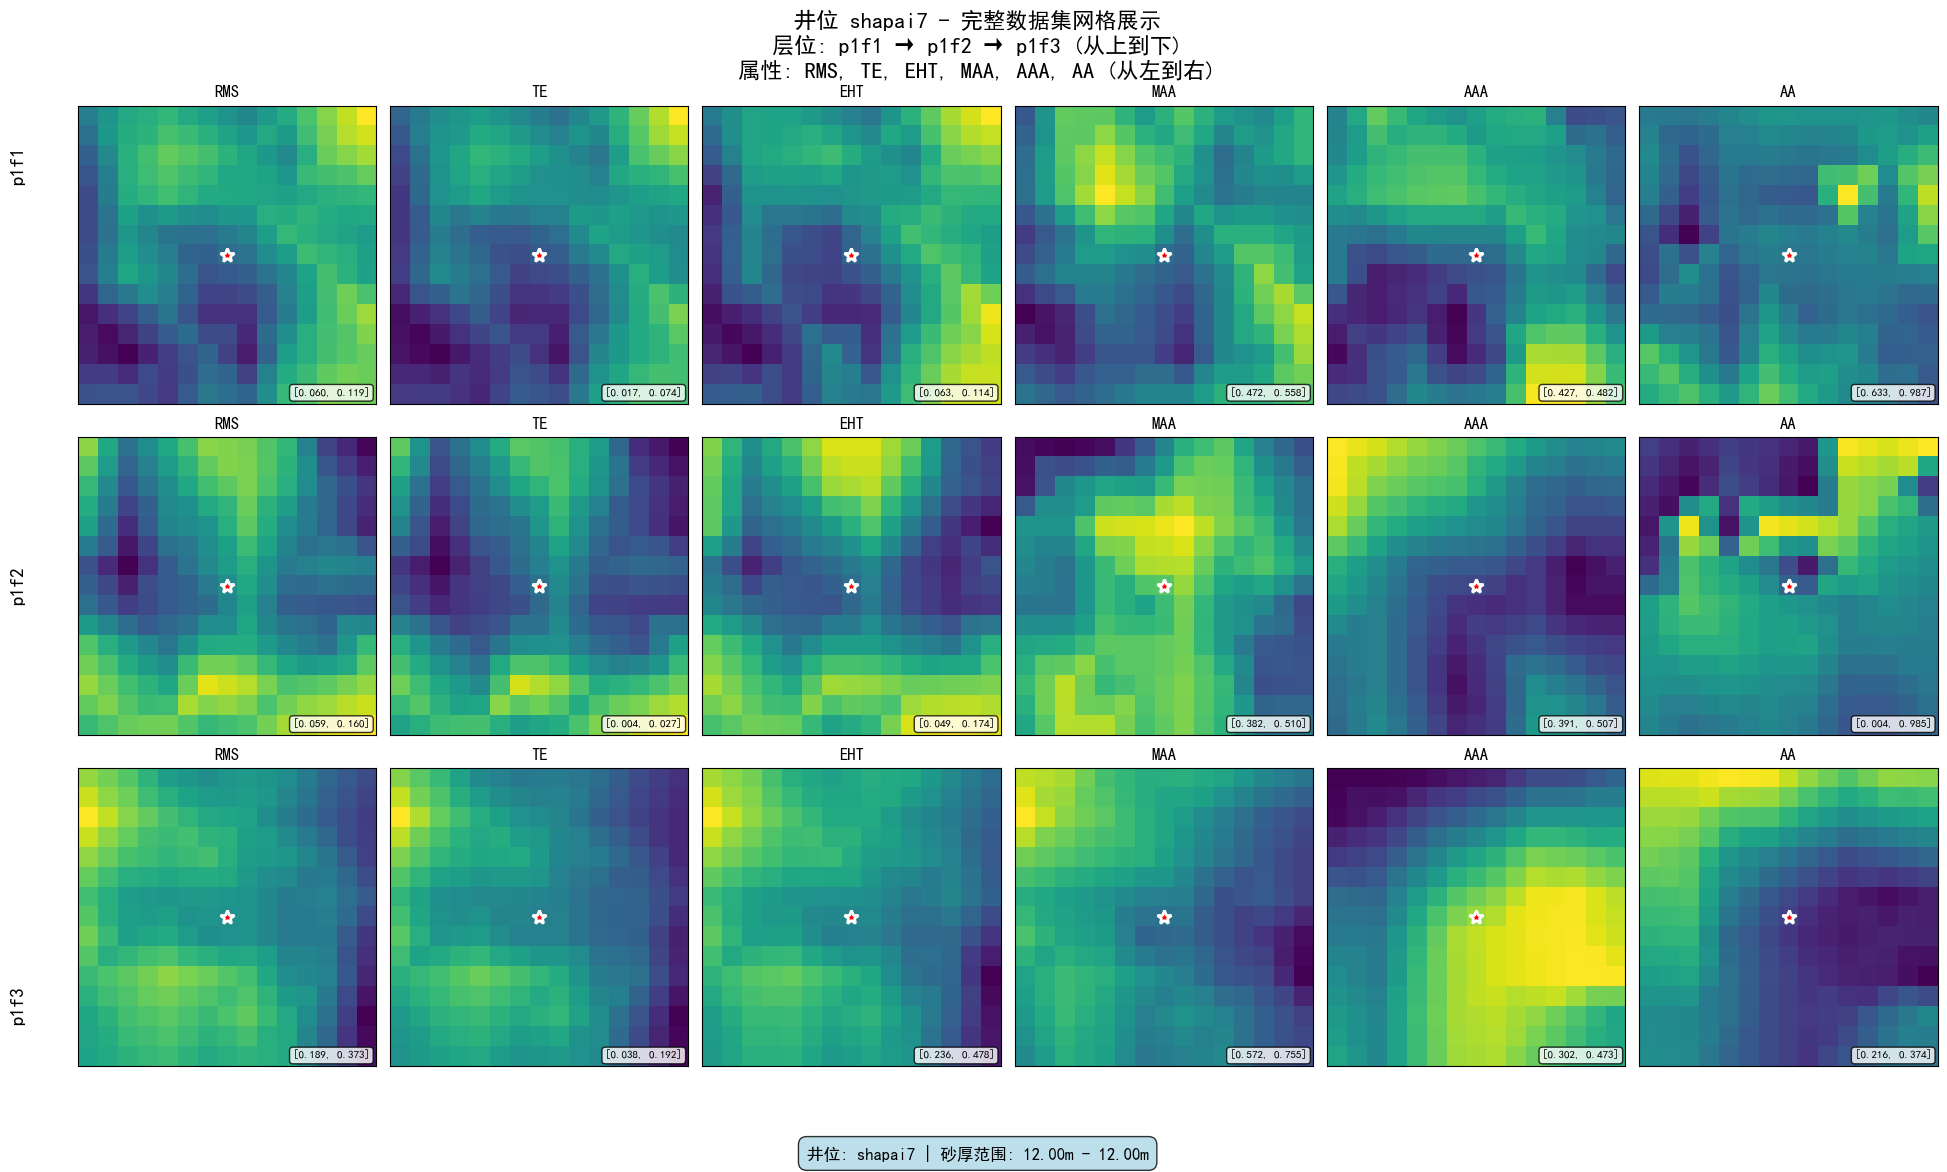


正在处理井位 2/8: shashen1
  处理层位 p1f1: 砂厚 52.00m
  处理层位 p1f2: 砂厚 72.00m
  处理层位 p1f3: 砂厚 52.00m
  保存图片: visualization_output/well_shashen1_complete_grid.png


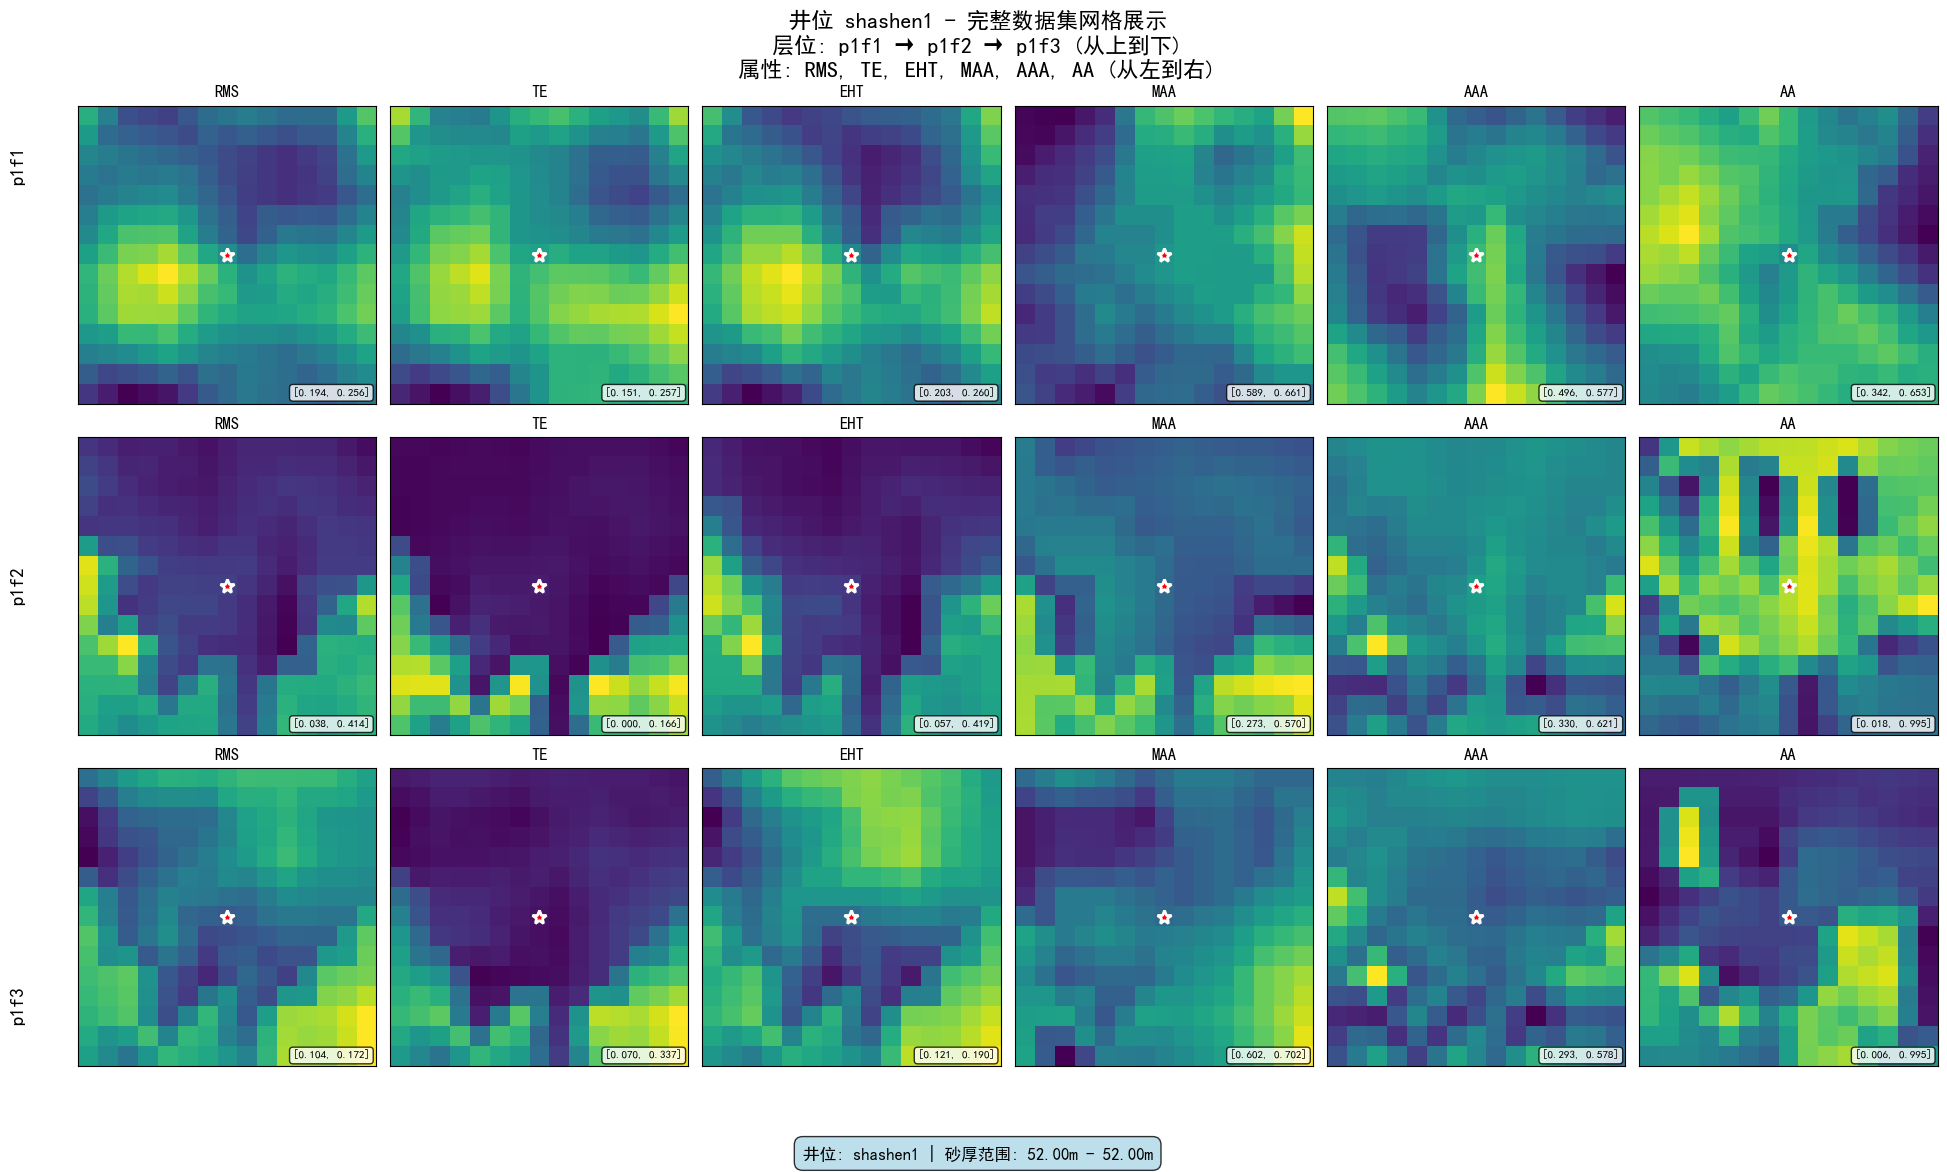


正在处理井位 3/8: tuantan1
  处理层位 p1f1: 砂厚 54.00m
  处理层位 p1f2: 砂厚 34.00m
  处理层位 p1f3: 砂厚 65.00m
  保存图片: visualization_output/well_tuantan1_complete_grid.png


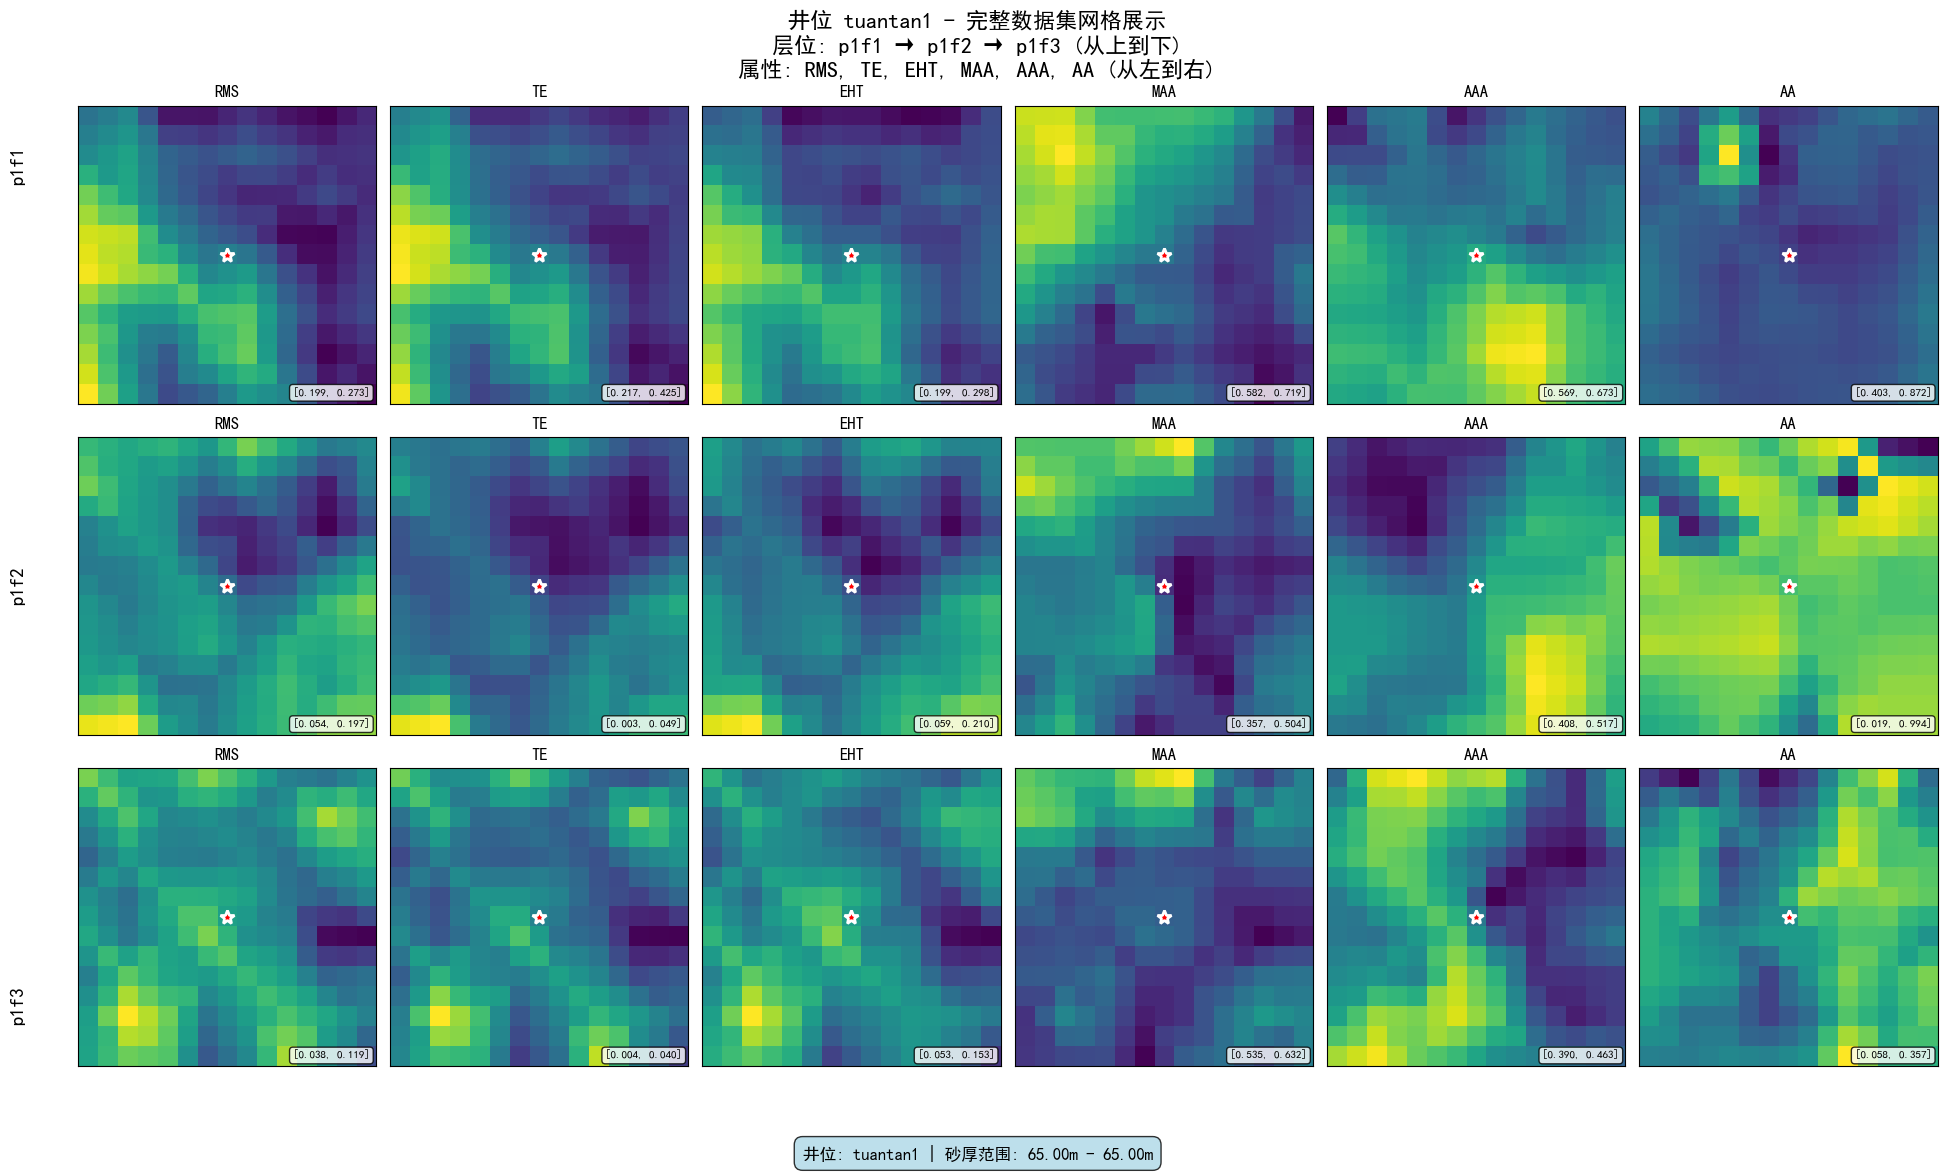


正在处理井位 4/8: wantan1
  处理层位 p1f1: 砂厚 27.00m
  处理层位 p1f2: 砂厚 25.00m
  处理层位 p1f3: 砂厚 21.00m
  保存图片: visualization_output/well_wantan1_complete_grid.png


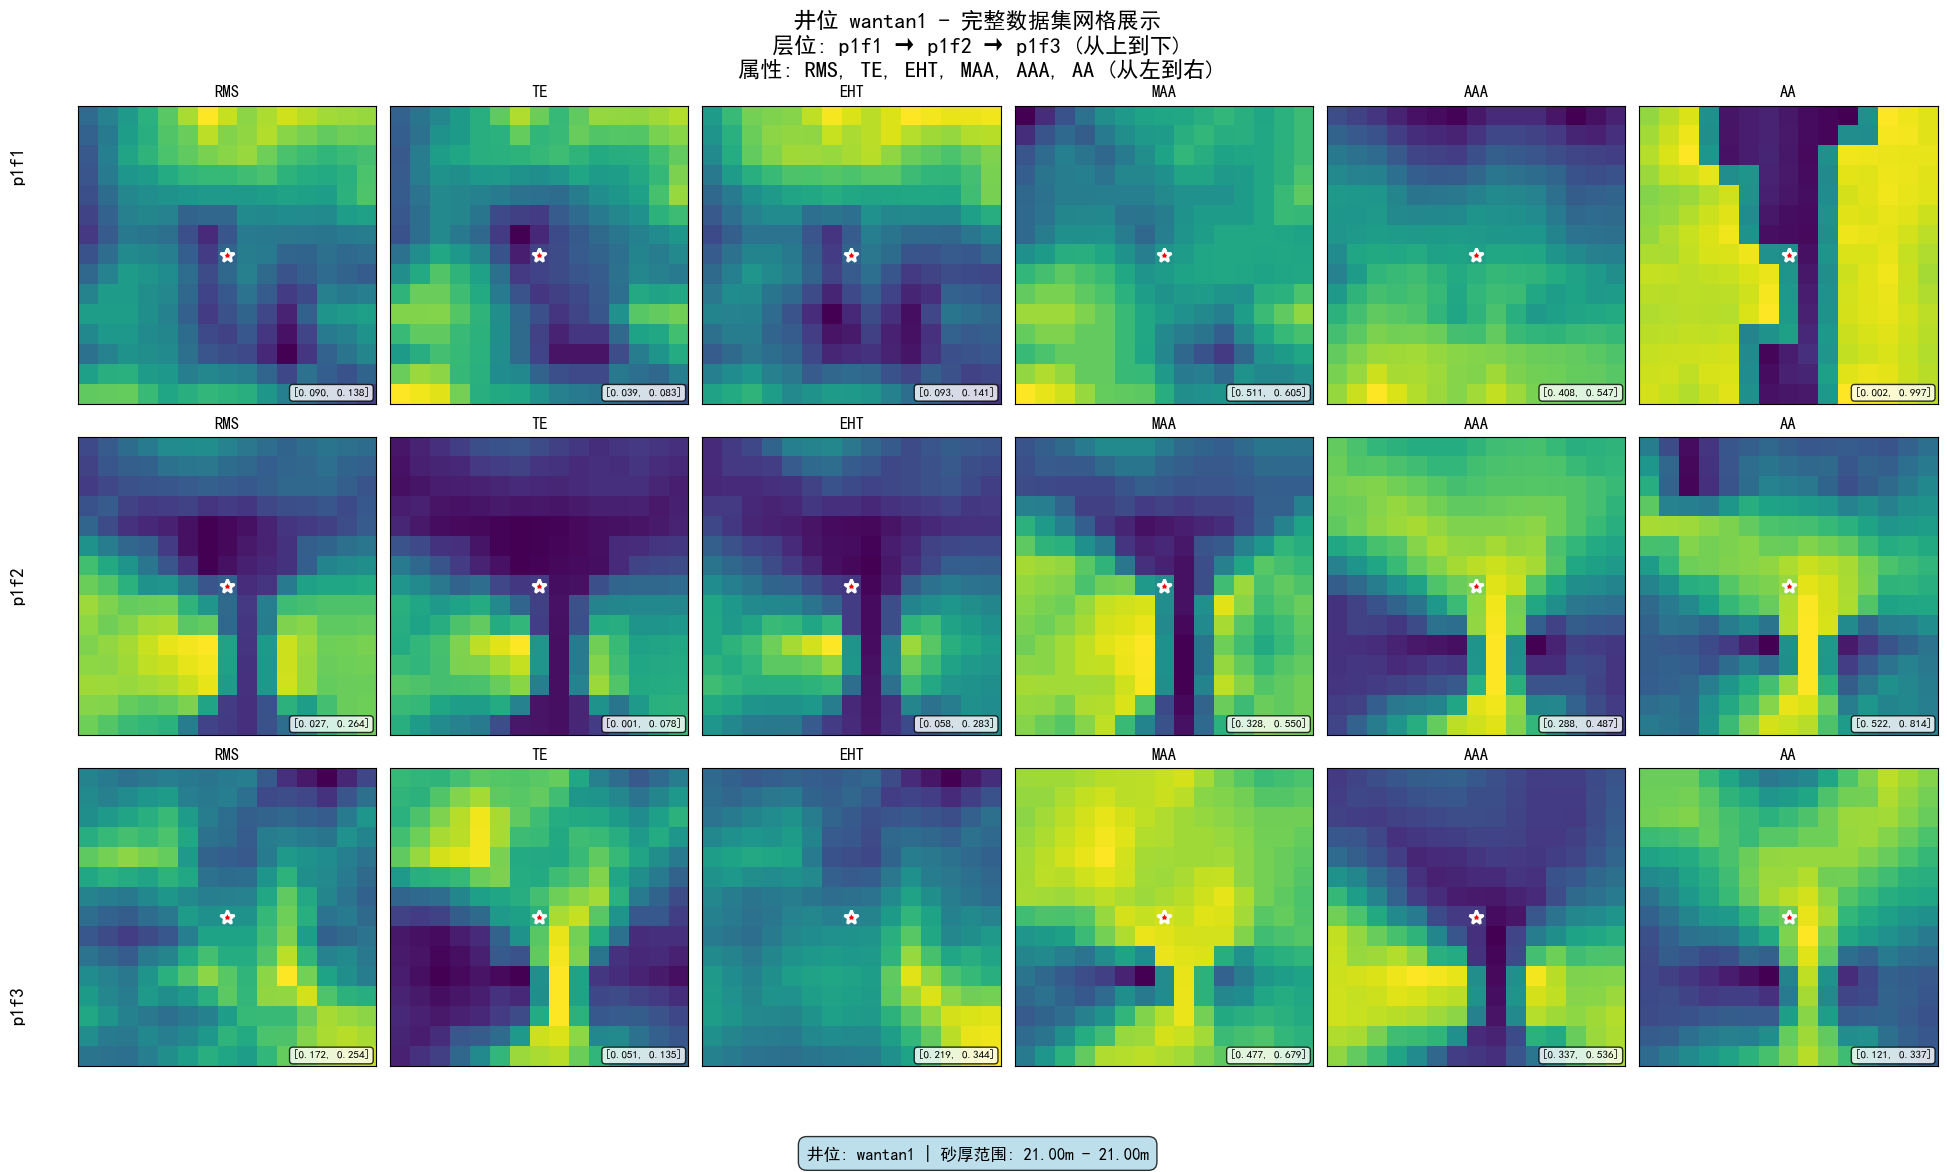


正在处理井位 5/8: zhengtan1
  处理层位 p1f1: 砂厚 0.00m
  处理层位 p1f2: 砂厚 53.00m
  处理层位 p1f3: 砂厚 29.00m
  保存图片: visualization_output/well_zhengtan1_complete_grid.png


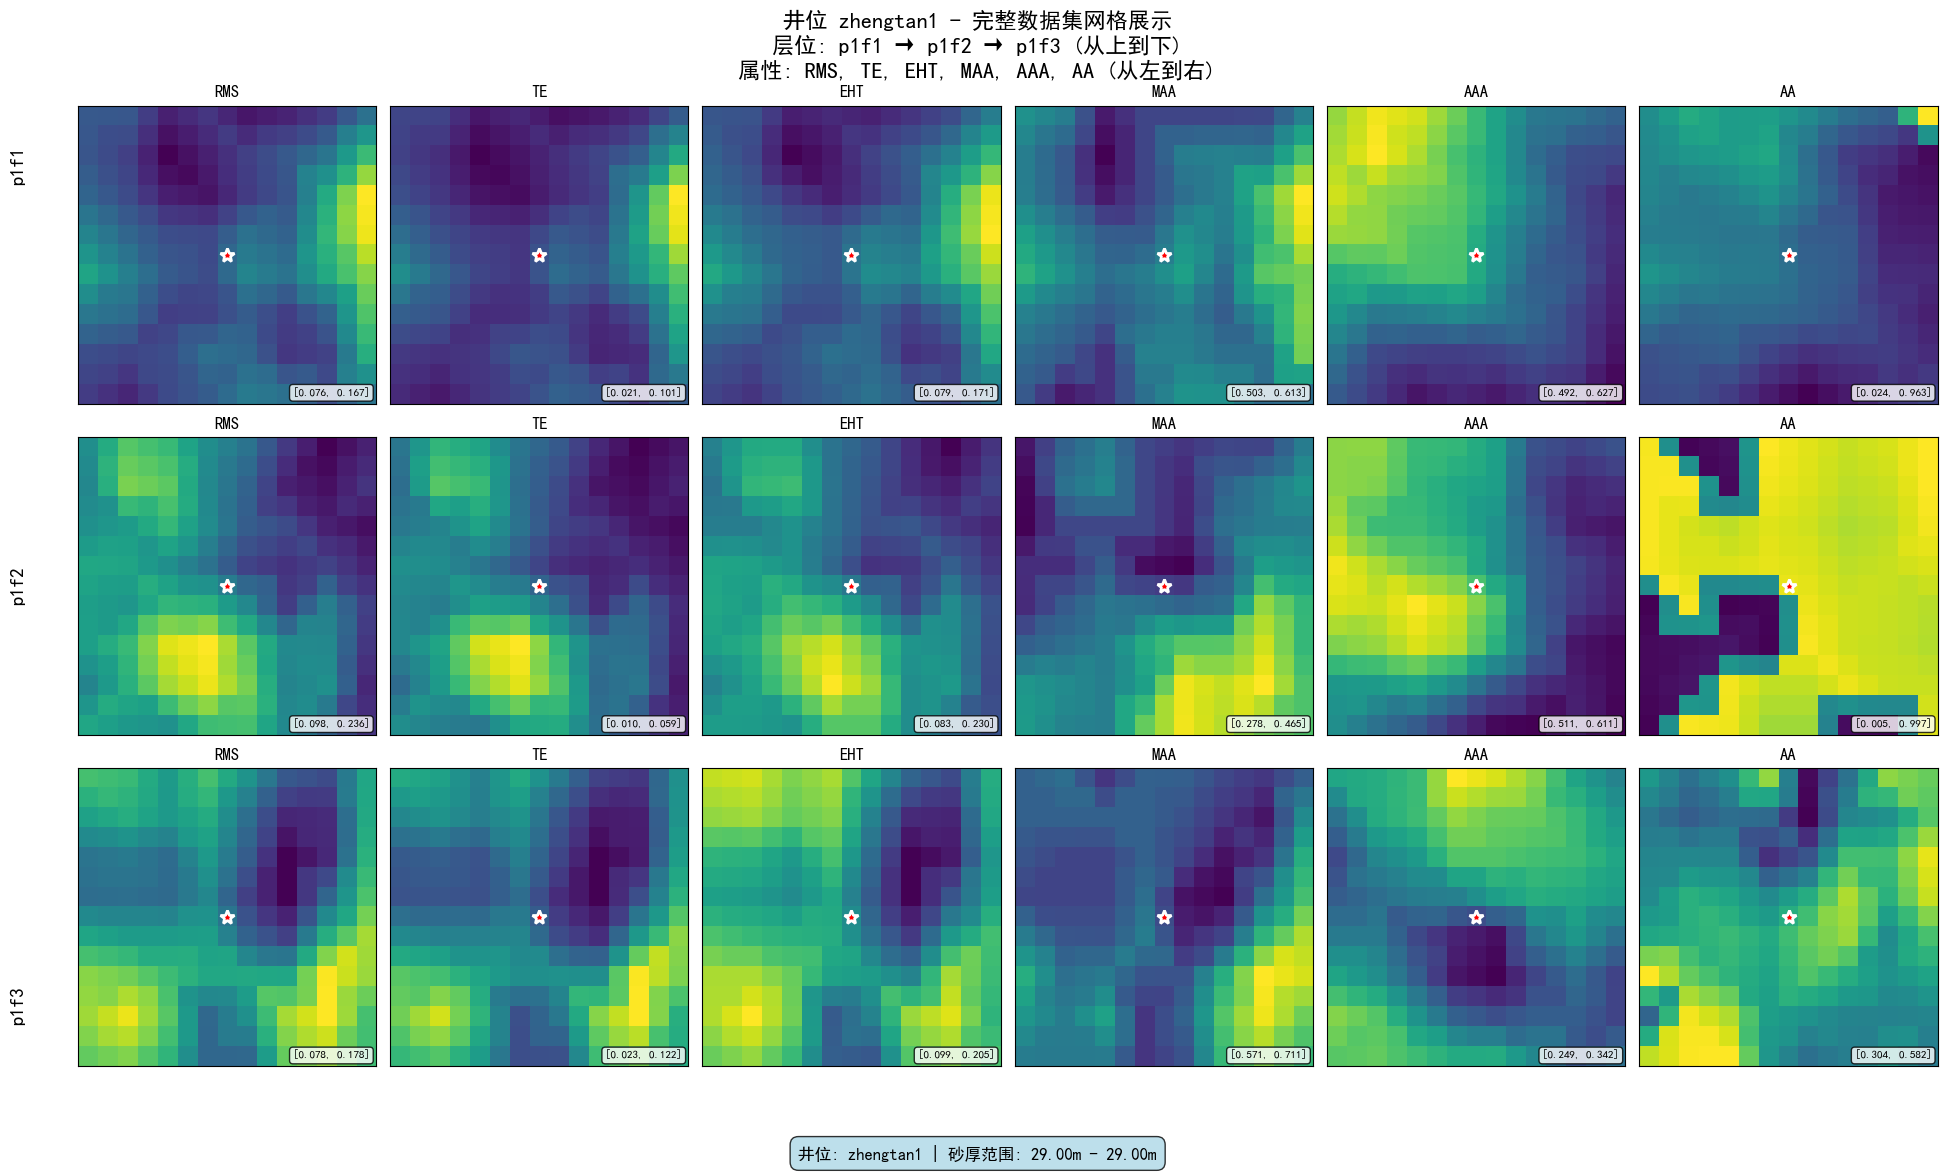


正在处理井位 6/8: zhongjia1
  处理层位 p1f1: 砂厚 28.00m
  处理层位 p1f2: 砂厚 16.00m
  处理层位 p1f3: 砂厚 24.00m
  保存图片: visualization_output/well_zhongjia1_complete_grid.png


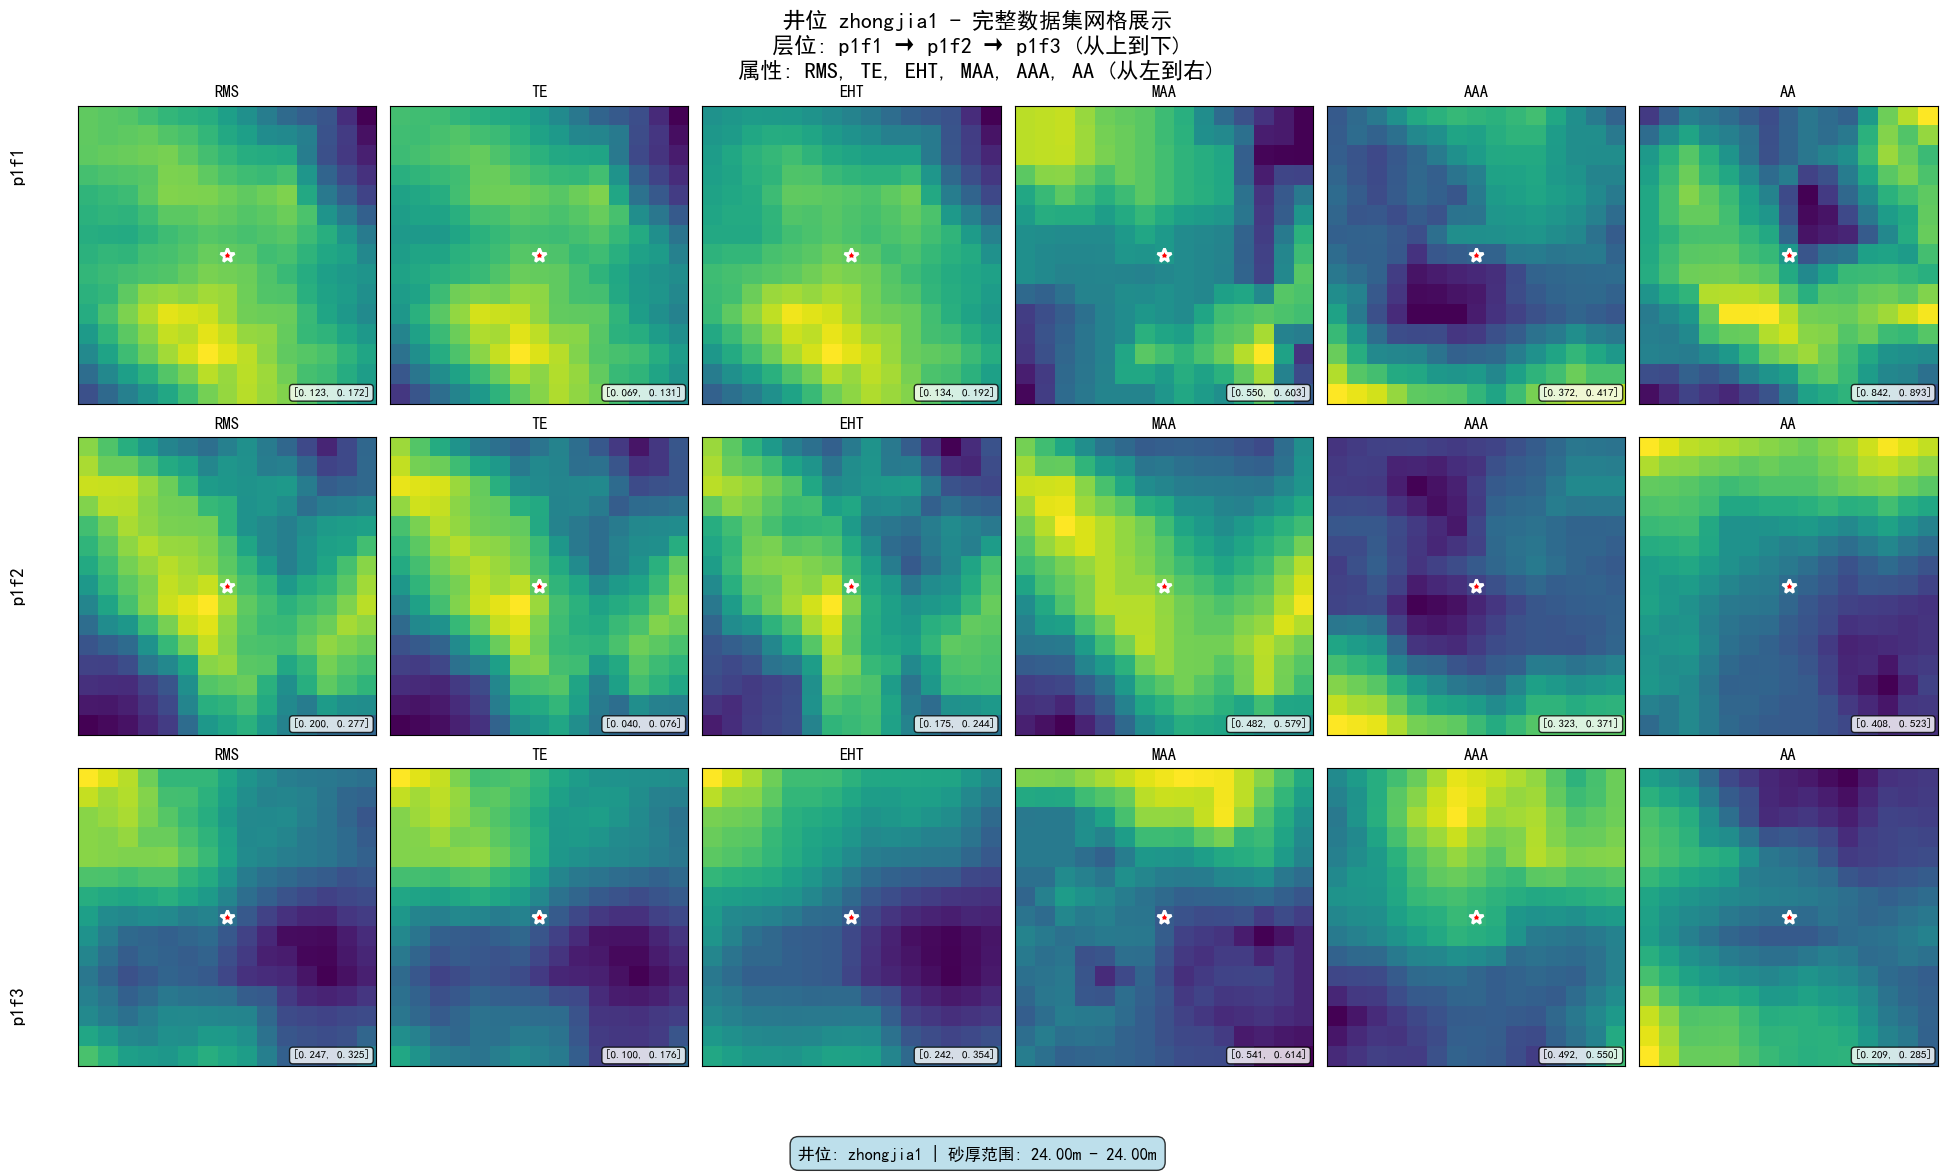


正在处理井位 7/8: zhongtan1
  处理层位 p1f1: 砂厚 48.00m
  处理层位 p1f2: 砂厚 52.00m
  处理层位 p1f3: 砂厚 68.00m
  保存图片: visualization_output/well_zhongtan1_complete_grid.png


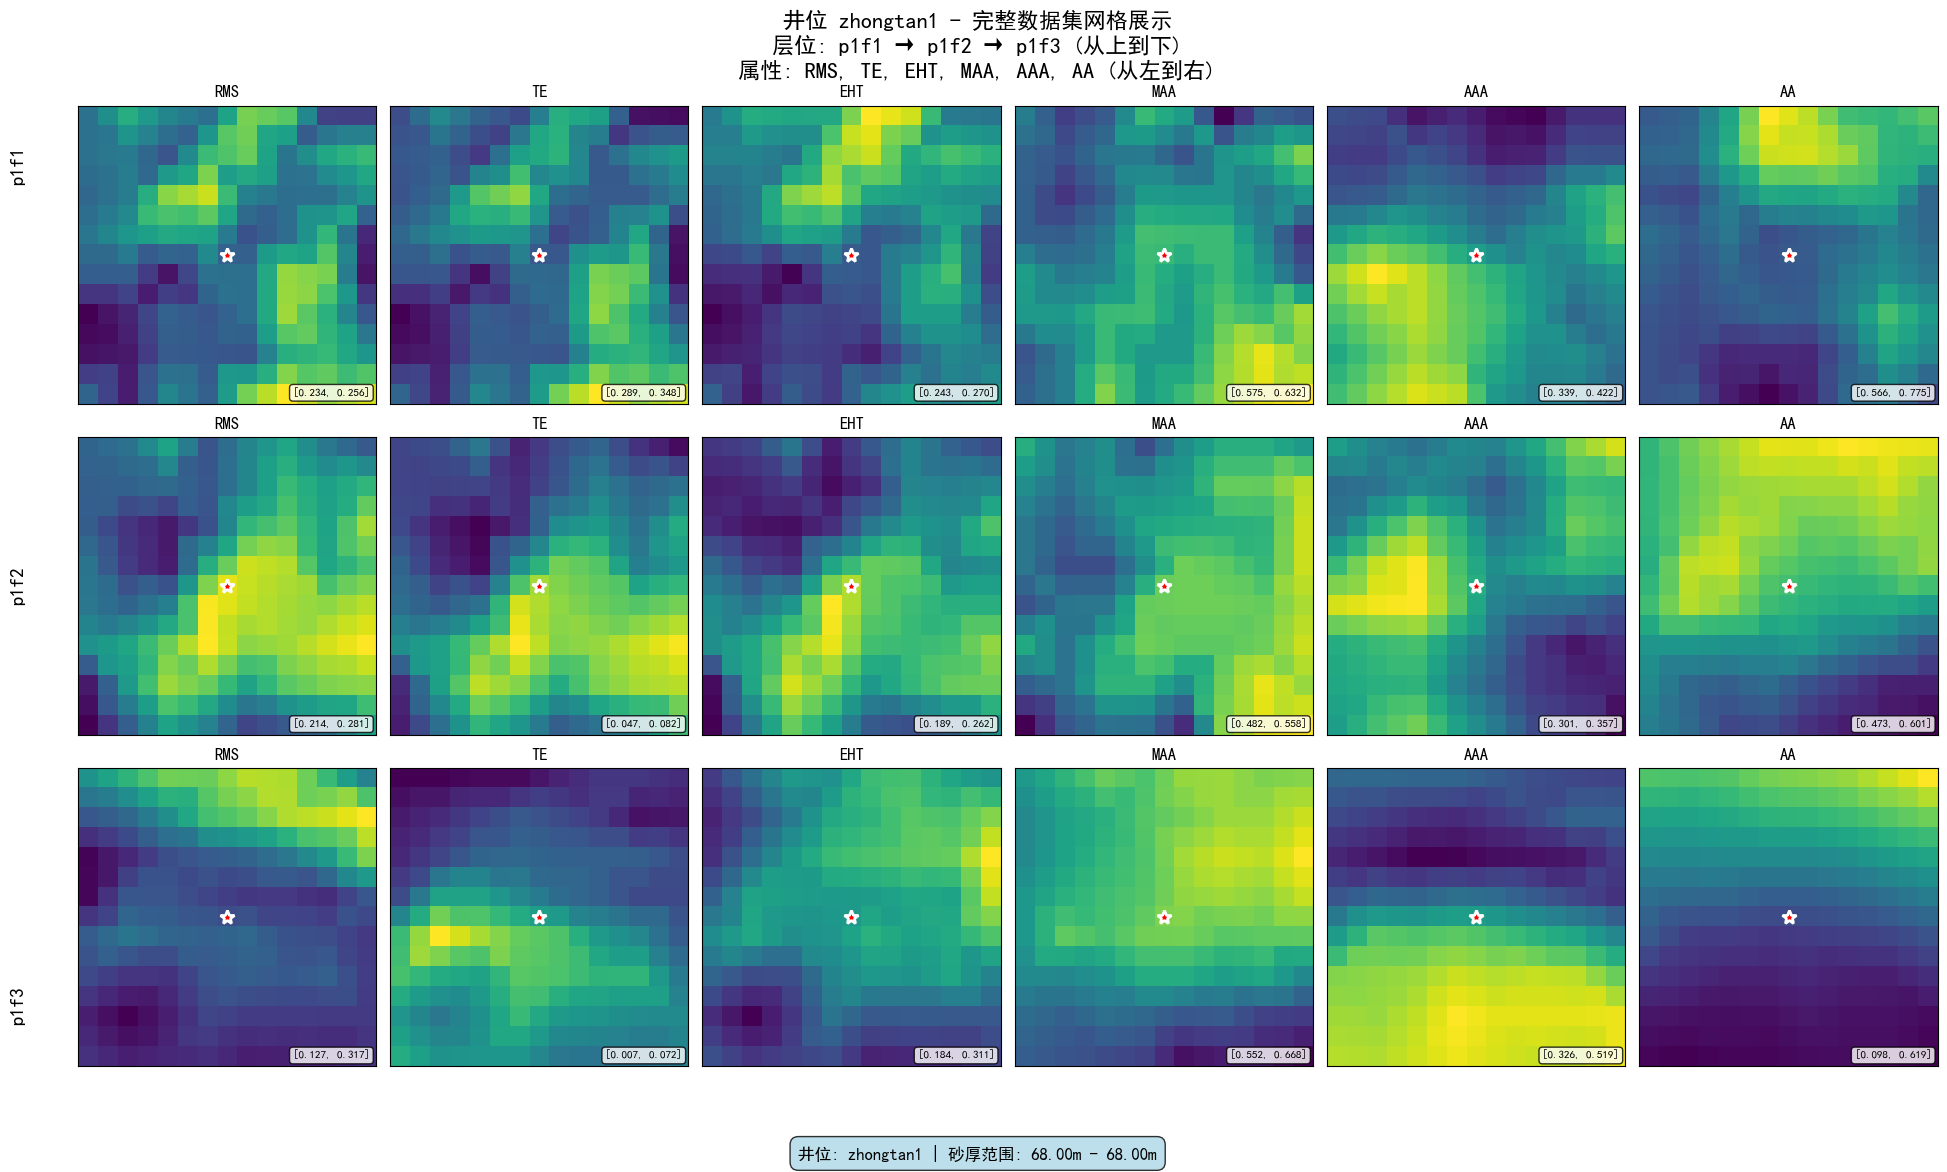


正在处理井位 8/8: zhuangshen1
  处理层位 p1f1: 砂厚 72.00m
  处理层位 p1f2: 砂厚 78.00m
  处理层位 p1f3: 砂厚 37.00m
  保存图片: visualization_output/well_zhuangshen1_complete_grid.png


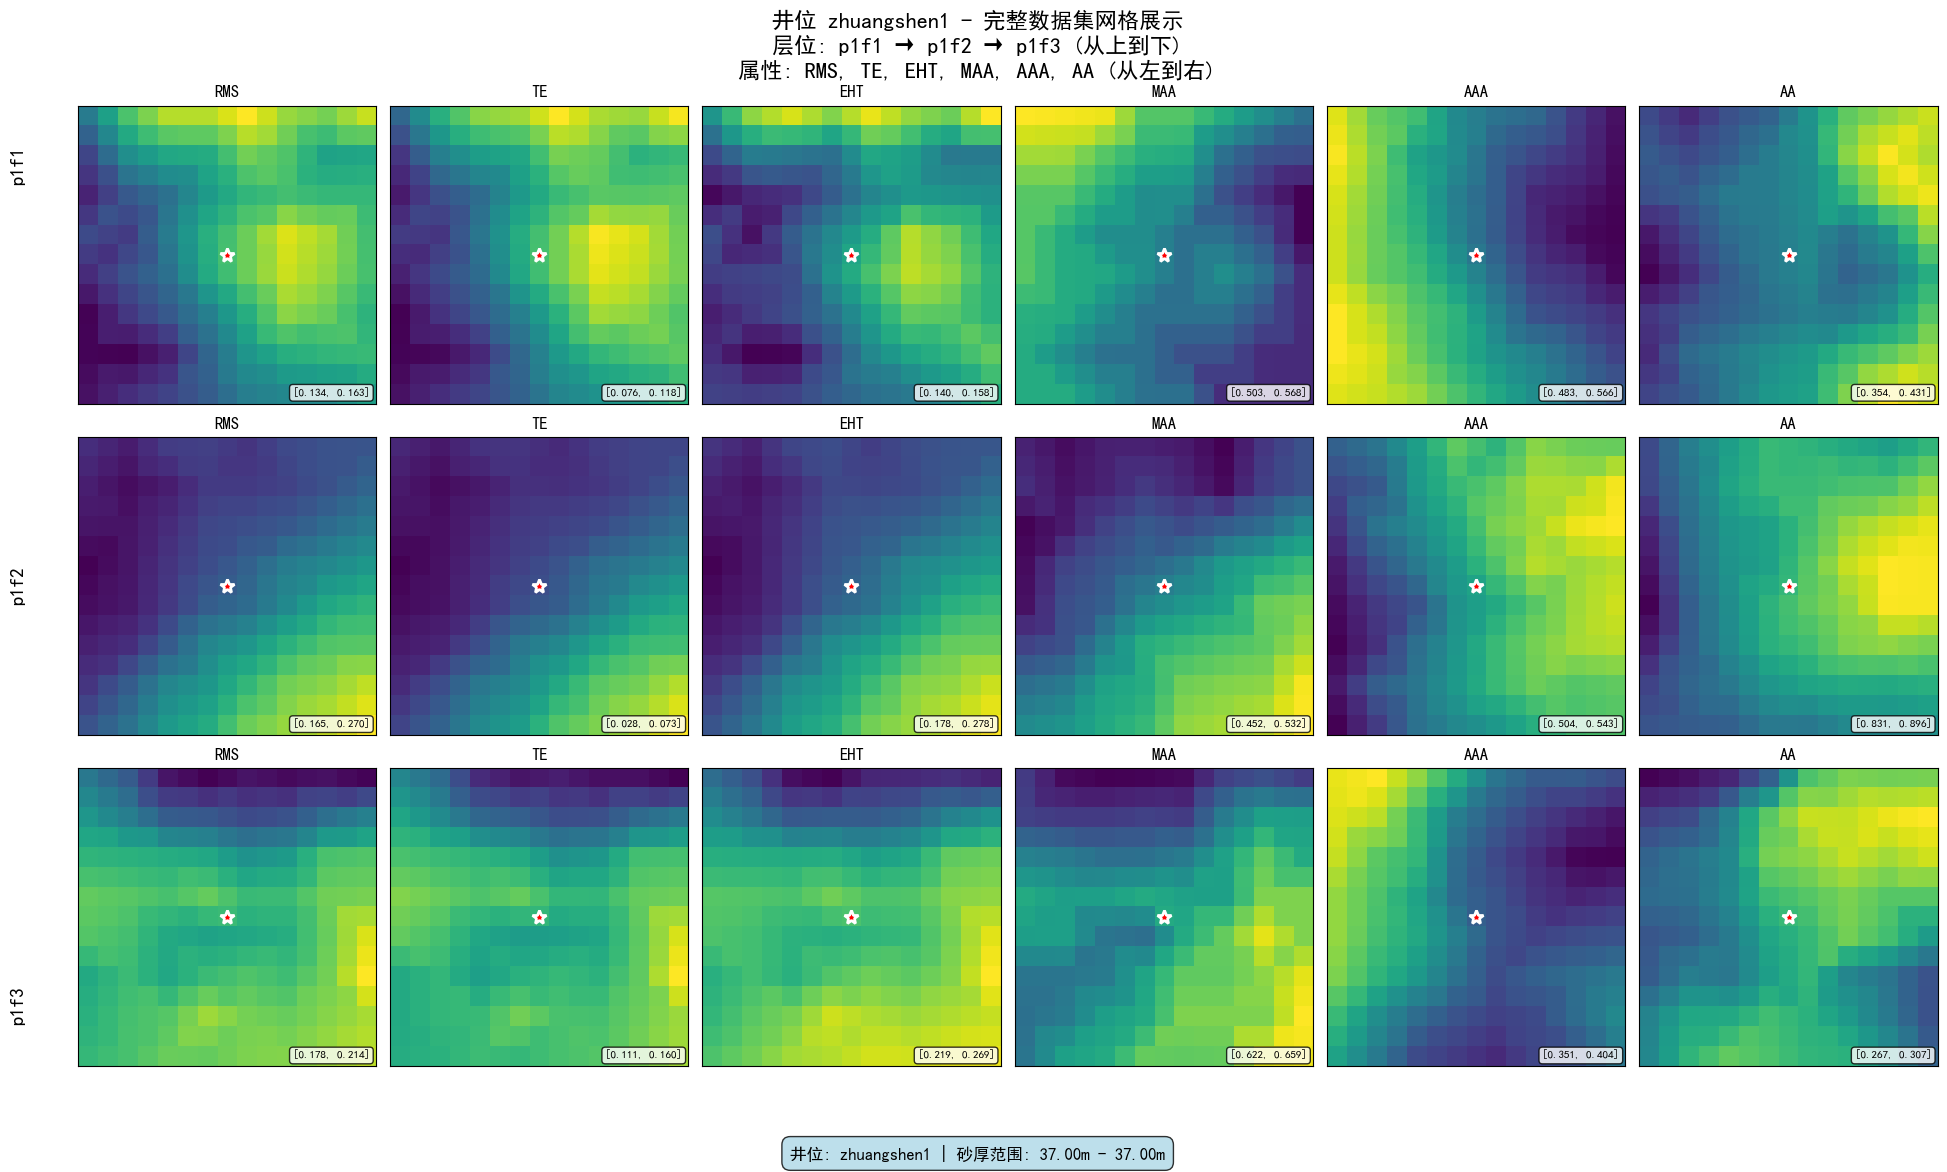


完成! 共生成 8 张井位网格展示图片
每张图片包含: 3个层位 × 6个属性 = 18个子图
层位顺序: p1f1 (上) → p1f2 (中) → p1f3 (下)
属性顺序: RMS, TE, EHT, MAA, AAA, AA (左到右)

按井分类的完整数据集网格展示完成!
每口井生成一张图片，包含3个层位×6个属性=18个子图


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import Normalize
import os
from matplotlib.colors import Normalize  
from sklearn.model_selection import train_test_split 

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 10

class CNNImageVisualizer:
    
    def __init__(self, data_path="processed_data/seismic_samples.pkl"):
        self.data_path = data_path
        self.attributes = ['RMS', 'TE', 'EHT', 'MAA', 'AAA', 'AA']
        self.samples_df = None
        self.output_dir = "visualization_output"
        
        os.makedirs(self.output_dir, exist_ok=True)
        
    def load_data(self):
        try:
            self.samples_df = pd.read_pickle(self.data_path)
            print(f"成功加载 {len(self.samples_df)} 个样本")
            print(f"图像形状: {self.samples_df.iloc[0]['image'].shape}")
            return True
        except Exception as e:
            print(f"数据加载失败: {e}")
            return False
    
    def visualize_single_sample(self, sample_idx=0, save=True):
        if self.samples_df is None:
            print("请先加载数据!")
            return
            
        sample = self.samples_df.iloc[sample_idx]
        image = sample['image']  
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'样本 {sample_idx}: {sample["well"]} - {sample["layer"]}\n'
                    f'砂厚: {sample["sand_thick"]:.2f}m, 坐标: ({sample["inline"]}, {sample["xline"]})', 
                    fontsize=16, fontweight='bold')
        
        if len(self.attributes) >= 6:
            self.attributes[2] = 'EHT'  # ARS → EHT
            self.attributes[4] = 'AAA'  # TAA → AAA
            self.attributes[5] = 'AA'   # AIP → AA

        for i, attr in enumerate(self.attributes):
            row, col = i // 3, i % 3
            ax = axes[row, col]
            
            channel_data = image[:, :, i]
            im = ax.imshow(channel_data, cmap='viridis', aspect='equal')
            ax.set_title(f'{attr}\nRange: [{channel_data.min():.3f}, {channel_data.max():.3f}]')
            ax.set_xlabel('XLine')
            ax.set_ylabel('InLine')
            
            plt.colorbar(im, ax=ax, shrink=0.8)
            
            center = image.shape[0] // 2
            ax.plot(center, center, 'r*', markersize=15, markeredgecolor='white', 
                   markeredgewidth=2, label='well')
            ax.legend()
        
        plt.tight_layout()
        
        if save:
            filename = f"{self.output_dir}/sample_{sample_idx}_{sample['well']}_{sample['layer']}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"保存图片: {filename}")
        
        plt.show()
    
    def visualize_multiple_samples(self, n_samples=6, save=True):
        if self.samples_df is None:
            print("请先加载数据!")
            return
            
        sample_indices = np.random.choice(len(self.samples_df), min(n_samples, len(self.samples_df)), replace=False)
        
        fig = plt.figure(figsize=(20, 4*len(sample_indices)))
        
        for i, idx in enumerate(sample_indices):
            sample = self.samples_df.iloc[idx]
            image = sample['image']
            
            for j, attr in enumerate(self.attributes):
                ax = plt.subplot(len(sample_indices), 6, i*6 + j + 1)
                
                channel_data = image[:, :, j]
                im = ax.imshow(channel_data, cmap='viridis', aspect='equal')
                
                if i == 0:  
                    ax.set_title(attr)
                
                if j == 0:  
                    ax.set_ylabel(f'{sample["well"]}\n砂厚:{sample["sand_thick"]:.1f}m', 
                                rotation=0, ha='right', va='center')
                
                ax.set_xticks([])
                ax.set_yticks([])
                
                center = image.shape[0] // 2
                ax.plot(center, center, 'r*', markersize=8, markeredgecolor='white')
        
        plt.tight_layout()
        
        if save:
            filename = f"{self.output_dir}/multiple_samples_grid.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"保存图片: {filename}")
        
        plt.show()
    
    def visualize_attribute_statistics(self, save=True):
        if self.samples_df is None:
            print("请先加载数据!")
            return
        
        all_attr_data = {attr: [] for attr in self.attributes}
        
        for _, sample in self.samples_df.iterrows():
            image = sample['image']
            for i, attr in enumerate(self.attributes):
                channel_data = image[:, :, i]
                all_attr_data[attr].extend(channel_data.flatten())
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('各地震属性数值分布统计', fontsize=16, fontweight='bold')
        
        for i, attr in enumerate(self.attributes):
            row, col = i // 3, i % 3
            ax = axes[row, col]
            
            data = np.array(all_attr_data[attr])
            data = data[~np.isnan(data)]  
            ax.hist(data, bins=50, alpha=0.7, density=True, color='skyblue')
            
            mean_val = np.mean(data)
            std_val = np.std(data)
            ax.axvline(mean_val, color='red', linestyle='--', label=f'均值: {mean_val:.3f}')
            ax.axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.7, label=f'±1σ')
            ax.axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.7)
            
            ax.set_title(f'{attr} 分布\n范围: [{data.min():.3f}, {data.max():.3f}]')
            ax.set_xlabel('数值')
            ax.set_ylabel('密度')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            filename = f"{self.output_dir}/attribute_statistics.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"保存图片: {filename}")
        
        plt.show()
    
    def visualize_sample_distribution(self, save=True):
        """可视化样本分布（层位、井位、砂厚等）"""
        if self.samples_df is None:
            print("请先加载数据!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('训练样本分布统计', fontsize=16, fontweight='bold')
        
        ax1 = axes[0, 0]
        layer_counts = self.samples_df['layer'].value_counts()
        bars = ax1.bar(layer_counts.index, layer_counts.values, color='lightcoral')
        ax1.set_title('各层位样本数量分布')
        ax1.set_ylabel('样本数量')
        ax1.tick_params(axis='x', rotation=45)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom')
        
        ax2 = axes[0, 1]
        well_counts = self.samples_df['well'].value_counts()
        ax2.pie(well_counts.values, labels=well_counts.index, autopct='%1.1f%%')
        ax2.set_title('各井位样本分布')
        
        ax3 = axes[1, 0]
        sand_thick = self.samples_df['sand_thick']
        ax3.hist(sand_thick, bins=20, alpha=0.7, color='gold', edgecolor='black')
        ax3.set_xlabel('砂厚 (m)')
        ax3.set_ylabel('样本数量')
        ax3.set_title(f'砂厚分布\n均值: {sand_thick.mean():.2f}m, 标准差: {sand_thick.std():.2f}m')
        ax3.grid(True, alpha=0.3)
        
        ax4 = axes[1, 1]
        radius_counts = self.samples_df['radius'].value_counts().sort_index()
        bars = ax4.bar(radius_counts.index, radius_counts.values, color='lightgreen')
        ax4.set_title('图像生成半径分布')
        ax4.set_xlabel('半径')
        ax4.set_ylabel('样本数量')
        
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        
        if save:
            filename = f"{self.output_dir}/sample_distribution.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"保存图片: {filename}")
        
        plt.show()
    
    def visualize_train_test_counts(self, train_df, test_df, save=True):
        
        if train_df is None or test_df is None:
            print("训练集或测试集数据为空!")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('训练集和测试集样本数量对比', fontsize=16, fontweight='bold')
        
        ax1 = axes[0]
        counts = [len(train_df), len(test_df)]
        labels = ['训练集', '测试集']
        colors = ['#2E8B57', '#DC143C']  
        
        bars = ax1.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
        ax1.set_title('样本数量对比', fontsize=14, fontweight='bold')
        ax1.set_ylabel('样本数量')
        ax1.set_ylim(0, max(counts) * 1.1)
        
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{count}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        total = sum(counts)
        for i, (label, count) in enumerate(zip(labels, counts)):
            percentage = count / total * 100
            ax1.text(i, count/2, f'{percentage:.1f}%', ha='center', va='center', 
                    fontsize=14, fontweight='bold', color='white')
        
        ax2 = axes[1]
        ax2.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', 
               startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
        ax2.set_title('样本比例分布', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        
        if save:
            filename = f"{self.output_dir}/train_test_sample_counts.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"保存图片: {filename}")
        
        plt.show()
    def visualize_layer_comparison(self, train_df, test_df, save=True):

        if train_df is None or test_df is None:
            print("训练集或测试集数据为空!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('训练集和测试集层位分布对比', fontsize=16, fontweight='bold')
        
        ax1 = axes[0, 0]
        train_layer_counts = train_df['layer'].value_counts().sort_index()
        test_layer_counts = test_df['layer'].value_counts().sort_index()
        
        x = np.arange(len(train_layer_counts))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, train_layer_counts.values, width, 
                       label='训练集', color='#2E8B57', alpha=0.8)
        bars2 = ax1.bar(x + width/2, test_layer_counts.values, width, 
                       label='测试集', color='#DC143C', alpha=0.8)
        
        ax1.set_xlabel('层位')
        ax1.set_ylabel('样本数量')
        ax1.set_title('各层位样本数量对比')
        ax1.set_xticks(x)
        ax1.set_xticklabels(train_layer_counts.index)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{int(height)}', ha='center', va='bottom', fontsize=10)
        
        ax2 = axes[0, 1]
        train_layer_pct = train_layer_counts / len(train_df) * 100
        test_layer_pct = test_layer_counts / len(test_df) * 100
        
        x = np.arange(len(train_layer_pct))
        bars1 = ax2.bar(x - width/2, train_layer_pct.values, width, 
                       label='训练集', color='#2E8B57', alpha=0.8)
        bars2 = ax2.bar(x + width/2, test_layer_pct.values, width, 
                       label='测试集', color='#DC143C', alpha=0.8)
        
        ax2.set_xlabel('层位')
        ax2.set_ylabel('比例 (%)')
        ax2.set_title('各层位样本比例对比')
        ax2.set_xticks(x)
        ax2.set_xticklabels(train_layer_pct.index)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3 = axes[1, 0]
        ax3.pie(train_layer_counts.values, labels=train_layer_counts.index, 
               autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        ax3.set_title('训练集层位分布')
        
        ax4 = axes[1, 1]
        ax4.pie(test_layer_counts.values, labels=test_layer_counts.index, 
               autopct='%1.1f%%', startangle=90, colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        ax4.set_title('测试集层位分布')
        
        plt.tight_layout()
        
        if save:
            filename = f"{self.output_dir}/train_test_layer_comparison.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"保存图片: {filename}")
        
        plt.show()
        
        print("\n层位分布对比:")
        for layer in train_layer_counts.index:
            train_count = train_layer_counts[layer]
            test_count = test_layer_counts[layer]
            train_pct = train_count / len(train_df) * 100
            test_pct = test_count / len(test_df) * 100
            print(f"{layer}: 训练集 {train_count}个({train_pct:.1f}%), 测试集 {test_count}个({test_pct:.1f}%)")
    
    def visualize_well_comparison(self, train_df, test_df, save=True):
        
        if train_df is None or test_df is None:
            print("训练集或测试集数据为空!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('训练集和测试集井位分布对比', fontsize=16, fontweight='bold')
        
        ax1 = axes[0, 0]
        train_well_counts = train_df['well'].value_counts()
        test_well_counts = test_df['well'].value_counts()
        
        all_wells = sorted(set(train_well_counts.index) | set(test_well_counts.index))
        train_counts = [train_well_counts.get(well, 0) for well in all_wells]
        test_counts = [test_well_counts.get(well, 0) for well in all_wells]
        
        x = np.arange(len(all_wells))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, train_counts, width, 
                       label='训练集', color='#2E8B57', alpha=0.8)
        bars2 = ax1.bar(x + width/2, test_counts, width, 
                       label='测试集', color='#DC143C', alpha=0.8)
        
        ax1.set_xlabel('井位')
        ax1.set_ylabel('样本数量')
        ax1.set_title('各井位样本数量对比')
        ax1.set_xticks(x)
        ax1.set_xticklabels(all_wells, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = axes[0, 1]
        train_pct = [count / len(train_df) * 100 for count in train_counts]
        test_pct = [count / len(test_df) * 100 for count in test_counts]
        
        bars1 = ax2.bar(x - width/2, train_pct, width, 
                       label='训练集', color='#2E8B57', alpha=0.8)
        bars2 = ax2.bar(x + width/2, test_pct, width, 
                       label='测试集', color='#DC143C', alpha=0.8)
        
        ax2.set_xlabel('井位')
        ax2.set_ylabel('比例 (%)')
        ax2.set_title('各井位样本比例对比')
        ax2.set_xticks(x)
        ax2.set_xticklabels(all_wells, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3 = axes[1, 0]
        ax3.pie(train_counts, labels=all_wells, autopct='%1.1f%%', startangle=90)
        ax3.set_title('训练集井位分布')
        
        ax4 = axes[1, 1]
        ax4.pie(test_counts, labels=all_wells, autopct='%1.1f%%', startangle=90)
        ax4.set_title('测试集井位分布')
        
        plt.tight_layout()
        
        if save:
            filename = f"{self.output_dir}/train_test_well_comparison.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"保存图片: {filename}")
        
        plt.show()
        
        print("\n井位分布对比:")
        for well in all_wells:
            train_count = train_well_counts.get(well, 0)
            test_count = test_well_counts.get(well, 0)
            train_pct = train_count / len(train_df) * 100
            test_pct = test_count / len(test_df) * 100
            print(f"{well}: 训练集 {train_count}个({train_pct:.1f}%), 测试集 {test_count}个({test_pct:.1f}%)")

    def visualize_all_samples_grid(self, save=True):
        """
        可视化完整数据集的多样本网格展示
        
        参数:
            n_samples (int): 展示样本数量，默认为12
            save (bool): 是否保存图片到文件，默认为True
        """
        if self.samples_df is None:
            print("请先加载数据!")
            return
        
        wells = sorted(self.samples_df['well'].unique())
        layers = ['p1f1', 'p1f2', 'p1f3'] 
        
        print(f"开始生成完整数据集网格展示...")
        print(f"井位数量: {len(wells)}")
        print(f"层位顺序: {layers}")
        print(f"总样本数: {len(self.samples_df)}")
        
        for well_idx, well in enumerate(wells):
            print(f"\n正在处理井位 {well_idx+1}/{len(wells)}: {well}")
            
            fig = plt.figure(figsize=(20, 12))
            fig.suptitle(f'井位 {well} - 完整数据集网格展示\n'
                        f'层位: {layers[0]} → {layers[1]} → {layers[2]} (从上到下)\n'
                        f'属性: {", ".join(self.attributes)} (从左到右)', 
                        fontsize=16, fontweight='bold')
            
            for layer_idx, layer in enumerate(layers):
                well_layer_samples = self.samples_df[
                    (self.samples_df['well'] == well) & 
                    (self.samples_df['layer'] == layer)
                ]
                
                if len(well_layer_samples) == 0:
                    print(f"  警告: 井位 {well} 在层位 {layer} 没有数据")
                    for attr_idx in range(6):
                        ax = plt.subplot(3, 6, layer_idx * 6 + attr_idx + 1)
                        ax.text(0.5, 0.5, f'无数据\n{layer}\n{self.attributes[attr_idx]}', 
                               ha='center', va='center', transform=ax.transAxes, fontsize=10)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        ax.set_title(f'{self.attributes[attr_idx]}', fontsize=12, fontweight='bold')
                    continue
                
                sample = well_layer_samples.iloc[0]
                image = sample['image']
                
                print(f"  处理层位 {layer}: 砂厚 {sample['sand_thick']:.2f}m")
                
                for attr_idx, attr in enumerate(self.attributes):
                    ax = plt.subplot(3, 6, layer_idx * 6 + attr_idx + 1)
                    
                    channel_data = image[:, :, attr_idx]
                    im = ax.imshow(channel_data, cmap='viridis', aspect='equal')
                    
                    ax.set_title(f'{attr}', fontsize=12, fontweight='bold')
                    
                    ax.set_xticks([])
                    ax.set_yticks([])
                    
                    center = image.shape[0] // 2
                    ax.plot(center, center, 'r*', markersize=10, markeredgecolor='white', markeredgewidth=2)
                    
                    ax.text(0.98, 0.02, f'[{channel_data.min():.3f}, {channel_data.max():.3f}]', 
                           transform=ax.transAxes, fontsize=8, ha='right', va='bottom',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                
                if layer_idx == 0:  
                    fig.text(0.02, 0.85, f'{layers[0]}', fontsize=14, fontweight='bold', 
                            rotation=90, ha='center', va='center')
                elif layer_idx == 1:
                    fig.text(0.02, 0.5, f'{layers[1]}', fontsize=14, fontweight='bold', 
                            rotation=90, ha='center', va='center')
                elif layer_idx == 2:
                    fig.text(0.02, 0.15, f'{layers[2]}', fontsize=14, fontweight='bold', 
                            rotation=90, ha='center', va='center')
            
            well_info = f'井位: {well} | 砂厚范围: {well_layer_samples["sand_thick"].min():.2f}m - {well_layer_samples["sand_thick"].max():.2f}m'
            fig.text(0.5, 0.02, well_info, fontsize=12, ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
            
            plt.tight_layout()
            plt.subplots_adjust(left=0.05, bottom=0.08, right=0.98, top=0.92)
            
            if save:
                filename = f"{self.output_dir}/well_{well}_complete_grid.png"
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"  保存图片: {filename}")
            
            plt.show()
        
    def generate_full_report(self):
        """生成完整的可视化报告"""
        print("="*60)
        print("开始生成CNN训练数据可视化报告")
        print("="*60)
        
        if not self.load_data():
            return
        
        print("\n1. 生成样本分布统计...")
        self.visualize_sample_distribution()
        
        print("\n2. 生成属性统计分布...")
        self.visualize_attribute_statistics()
        
        print("\n3. 生成单个样本详细展示...")
        self.visualize_single_sample(sample_idx=0)
        
        print("\n4. 生成多样本网格展示...")
        self.visualize_multiple_samples(n_samples=4)

        print("\n5. 生成完整数据集多样本网格展示...")
        self.visualize_all_samples_grid()

        print(f"\n所有可视化结果已保存至: {self.output_dir}/")
        print("="*60)
        print("可视化报告生成完成!")
        print("="*60)


if __name__ == "__main__":
  
    visualizer = CNNImageVisualizer()
    
    visualizer.generate_full_report()
    
if visualizer.load_data():
    print("数据加载成功，开始生成按井分类的完整数据集网格展示...")
 
    visualizer.visualize_all_samples_grid()
    
    print("\n按井分类的完整数据集网格展示完成!")
    print("每口井生成一张图片，包含3个层位×6个属性=18个子图")
else:
    print("数据加载失败!")


### 二维卷积模型训练

=== 地震属性CNN模型训练 ===

数据集统计:
- 有效样本数: 216
- 无效样本数: 0
- 图像形状: (15, 15, 6)

数据拆分结果:
- 训练集: 151 样本
- 测试集: 65 样本
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 15, 15, 32)        1760      
                                                                 
 conv2d_29 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 7, 7, 32)          0         
                                                                 
 conv2d_30 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_31 (

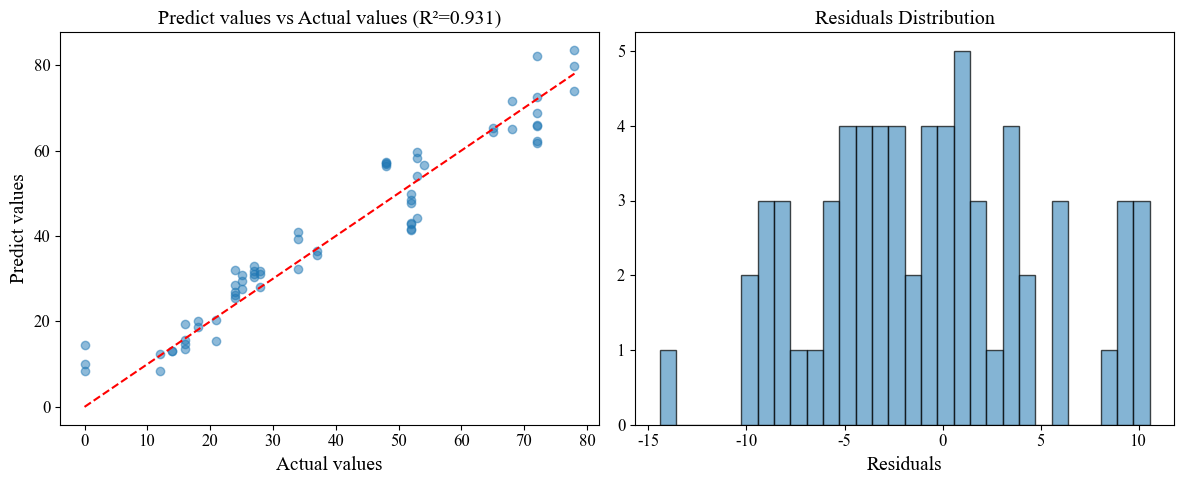


模型已保存为 seismic_cnn_model.h5


NameError: name 'mae' is not defined

In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tqdm import tqdm

# 设置默认英文字体为 Times New Roman (图片中英文标签的常见serif字体)
plt.rcParams['font.family'] = ['Times New Roman', 'serif']

# 常量定义
ATTRIBUTES = ['RMS', 'TE', 'EHT', 'MAA', 'AAA', 'AA']

def safe_load_dataset():
    """安全加载数据集"""
    try:
        if not os.path.exists("processed_data/seismic_samples.pkl"):
            raise FileNotFoundError("数据集文件不存在")
            
        with open("processed_data/seismic_samples.pkl", 'rb') as f:
            data = pickle.load(f)
        
        df = pd.DataFrame(data)
        
        if df.empty:
            raise ValueError("加载的数据集为空")
            
        required_cols = ['image', 'sand_thick']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"缺少必要列: {missing_cols}")
            
        valid_images = []
        valid_labels = []
        for idx, row in df.iterrows():
            try:
                if isinstance(row['image'], np.ndarray) and row['image'].any():
                    valid_images.append(row['image'])
                    valid_labels.append(row['sand_thick'])
            except:
                print(f"! 跳过无效样本 {idx}")
                continue
        if not valid_images:
            raise ValueError("无有效图像数据")
        X = np.stack(valid_images)
        y = np.array(valid_labels)
        
        scaler = StandardScaler()
        X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        
        print("\n数据集统计:")
        print(f"- 有效样本数: {len(X)}")
        print(f"- 无效样本数: {len(df) - len(X)}")
        print(f"- 图像形状: {X.shape[1:]}")
        
        return X, y, ATTRIBUTES
        
    except Exception as e:
        print(f"! 数据加载失败: {str(e)}")
        return None, None, None

def safe_prepare_data(X, y, test_size=0.3):
    
    if X is None or y is None:
        raise ValueError("输入数据为空")
    if len(X) != len(y):
        raise ValueError(f"数据长度不匹配: X={len(X)}, y={len(y)}")
        
    if len(X) < 2:
        raise ValueError(f"样本数不足: {len(X)}")
        
    try:
        if len(y) >= 10:
            bins = np.linspace(min(y), max(y), min(5, len(y)//2))
            y_binned = np.digitize(y, bins)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, stratify=y_binned, random_state=42
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42
            )
            
        print("\n数据拆分结果:")
        print(f"- 训练集: {X_train.shape[0]} 样本")
        print(f"- 测试集: {X_test.shape[0]} 样本")
        
        return X_train, X_test, y_train, y_test
        
    except Exception as e:
        print(f"! 数据准备失败: {str(e)}")
        return None, None, None, None

def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2), 
        Dropout(0.2),
       
        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2),
        Dropout(0.3),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=MeanSquaredError(),
        metrics=[MeanAbsoluteError()]
    )
    
    return model

def safe_model_training(model, X_train, y_train, X_test, y_test):
    if X_train is None or len(X_train) == 0:
        raise ValueError("训练数据无效")
    
    try:
        if X_train.ndim != 4:
            raise ValueError(f"输入维度应为4维，实际得到: {X_train.shape}")
        
        callbacks = [
            EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
            ModelCheckpoint('best_model.h5', save_best_only=True)
        ]
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=16,
            callbacks=callbacks,
            verbose=1
        )
        
        try:
            import json
            with open('training_history.json', 'w', encoding='utf-8') as f:
                json.dump({'loss': history.history.get('loss', []),
                           'val_loss': history.history.get('val_loss', [])},
                          f, ensure_ascii=False)
            print("已保存训练曲线到: training_history.json")
        except Exception as save_err:
            print(f"训练曲线保存失败: {save_err}")
        
        return history
    
    except Exception as e:
        print(f"! 训练过程中出错: {str(e)}")
        return None

def evaluate_results(model, X_test, y_test):
    try:
        y_pred = model.predict(X_test).flatten()
        
        mse = MeanSquaredError()(y_test, y_pred).numpy()
        mae = MeanAbsoluteError()(y_test, y_pred).numpy()
        r2 = r2_score(y_test, y_pred)
        
        print("\n测试集评估:")
        print(f"- MSE: {mse:.4f}")
        print(f"- MAE: {mae:.4f}")
        print(f"- R²: {r2:.4f}")
         
        plt.figure(figsize=(12,5))
        
        plt.subplot(1,2,1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel('Actual values')
        plt.ylabel('Predict values')
        plt.title(f'Predict values vs Actual values (R²={r2:.3f})')
        
        plt.subplot(1,2,2)
        residuals = y_test - y_pred
        plt.hist(residuals, bins=30,alpha=0.7,color='#5094C3',edgecolor='black')
        plt.xlabel('Residuals')
        plt.title('Residuals Distribution')
        
        plt.tight_layout()
        plt.savefig('model_performance.png')
        plt.show()
        
        return r2
        
    except Exception as e:
        print(f"! 评估失败: {str(e)}")
        return None

def main():
    print("=== 地震属性CNN模型训练 ===")
    
    X, y, attrs = safe_load_dataset()
    if X is None:
        return
        
    X_train, X_test, y_train, y_test = safe_prepare_data(X, y)
    if X_train is None:
        return
        
    try:
        model = build_cnn_model(X_train.shape[1:])
        model.summary()
    except Exception as e:
        print(f"! 模型构建失败: {str(e)}")
        return
        
    history = safe_model_training(model, X_train, y_train, X_test, y_test)
    if history is None:
        return
        
    r2 = evaluate_results(model, X_test, y_test)
    
    if r2 is not None and r2 > 0: 
        model.save('seismic_cnn_model.h5')
        print("\n模型已保存为 seismic_cnn_model.h5")
        
        with open('training_results.txt', 'w', encoding='utf-8') as f:
            f.write(f"R²: {r2:.4f}\n")
            f.write(f"MAE: {mae:.4f}\n")
            f.write(f"样本数: {len(X)}\n")
    else:
        print("! 模型性能不佳，未保存")

if __name__ == "__main__":
    main()

### 结果预测

In [ ]:
import numpy as np
import pandas as pd
import pickle
import os
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from tqdm import tqdm
from tensorflow.keras.models import load_model
import time

def smart_load_attribute(file_path, attribute_name):
   
    try:
        df = pd.read_csv(file_path,
                         sep='\s+', 
                         header=0,  
                         usecols=['InLine', 'XLine', 'Value'],  
                         dtype={'InLine': int, 'XLine': int, 'Value': float})
        
        df = df.rename(columns={'Value': attribute_name})
        
        print(f"  成功加载 {attribute_name}: {len(df)} 个点 (InLine范围: {df['InLine'].min()}-{df['InLine'].max()})")
        return df
        
    except Exception as e:
        print(f"! 加载属性 {attribute_name} 失败: {str(e)}")
        return None

def predict_well_layers_enhanced(layer_names, model):
    print("="*60)
    print("🚀 开始增强版层位预测")
    print("="*60)
    print(f"📋 预测层位: {', '.join(layer_names)}")
    params = {
        'image_width': 15,  
        'attribute_names': ['RMS','TE','ARS','MAA','TAA','AIP'], 
        'step_size': 10,    
        'batch_size': 16   
    }
    
    print(f"⚙️  配置参数:")
    print(f"   - 图像块尺寸: {params['image_width']}×{params['image_width']}")
    print(f"   - 地震属性: {', '.join(params['attribute_names'])}")
    print(f"   - 采样步长: {params['step_size']}")
    print(f"   - 批处理大小: {params['batch_size']}")
    
   
    os.makedirs("predict_results", exist_ok=True)
    print(f"📁 结果将保存到: predict_results/")

    print(f"\n[1/6] 🔧 正在加载数据标准化器...")
    try:
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        print("  ✓ 标准化器加载成功")
    except FileNotFoundError:
        print("  ⚠️  警告: 未找到标准化器文件，预测结果可能不准确")
        scaler = None
    except Exception as e:
        print(f"  ✗ 标准化器加载失败: {str(e)}")
        scaler = None

    total_start_time = time.time()  
    
    for layer_idx, layer in enumerate(layer_names, 1):
        print(f"\n{'='*50}")
        print(f"🎯 开始预测层位 {layer_idx}/{len(layer_names)}: {layer}")
        print(f"{'='*50}")
        
        layer_start_time = time.time()  
        print(f"[2/6] 📊 正在加载 {layer} 层位的地震属性数据...")
        attr_data = {} 
        for attr in params['attribute_names']: 
            file_path = os.path.join("attribute-小层", f"{layer}-{attr}.txt")
             
            df = smart_load_attribute(file_path, attr)
            if df is not None:
                attr_data[attr] = df
         
        if not attr_data:
            print(f"  ✗ 层位 {layer} 无有效属性数据，跳过")
            continue
        
        loaded_attrs = list(attr_data.keys())
        missing_attrs = set(params['attribute_names']) - set(loaded_attrs)
        if missing_attrs:
            print(f"  ⚠️  缺少属性: {', '.join(missing_attrs)}")
        
        print(f"  ✓ 成功加载 {len(loaded_attrs)} 种属性")
 
        print(f"[3/6] 🔗 正在合并属性数据...")
        try: 
            predict_data = attr_data[loaded_attrs[0]][['InLine', 'XLine']].copy()
             
            for attr in loaded_attrs[1:]:
                predict_data = pd.merge(
                    predict_data,
                    attr_data[attr][['InLine', 'XLine', attr]],
                    on=['InLine', 'XLine'],
                    how='inner'   
                )
            
            print(f"  ✓ 合并完成，共 {len(predict_data):,} 个有效数据点")
            
        except Exception as e:
            print(f"  ✗ 数据合并失败: {str(e)}")
            continue
 
        print(f"[4/6] 🗺️  正在生成稀疏采样网格...")
         
        all_coords = predict_data[['InLine', 'XLine']].drop_duplicates()
        coord_array = all_coords.values
         
        tree = cKDTree(coord_array)
         
        min_il, max_il = all_coords['InLine'].min(), all_coords['InLine'].max()
        min_xl, max_xl = all_coords['XLine'].min(), all_coords['XLine'].max()
        
        print(f"  坐标范围: InLine[{min_il}-{max_il}], XLine[{min_xl}-{max_xl}]")
         
        sparse_set = set()
        for inline in range(min_il, max_il + 1, params['step_size']):
            for xline in range(min_xl, max_xl + 1, params['step_size']): 
                _, nearest_idx = tree.query([inline, xline])
                point = (coord_array[nearest_idx][0], coord_array[nearest_idx][1])
                sparse_set.add(point)
        
        sparse_coords = list(sparse_set)
        sparse_count = len(sparse_coords)
        reduction_factor = len(all_coords) / sparse_count if sparse_count > 0 else 1
        
        print(f"  ✓ 网格点总数: {len(all_coords):,}")
        print(f"  ✓ 稀疏点数量: {sparse_count:,}")
        print(f"  ✓ 计算加速比: ~{reduction_factor:.1f}倍")
 
        print(f"[5/6] 🧠 正在生成图像块并进行CNN预测...")
        
        predictions = {}   
        image_blocks = []  
        coordinates = []   
        processed_points = 0
         
        with tqdm(sparse_coords, desc=f"预测 {layer}", unit="点") as pbar:
            for inline, xline in pbar: 
                if (inline, xline) in predictions:
                    continue
                 
                image_block = np.zeros((
                    params['image_width'], 
                    params['image_width'], 
                    len(params['attribute_names'])
                )) 
                for channel_idx, attr in enumerate(params['attribute_names']):
                    if attr in attr_data:
                        attr_df = attr_data[attr]
                         
                        values = attr_df[
                            (attr_df['InLine'] >= inline - params['image_width']//2) &
                            (attr_df['InLine'] <= inline + params['image_width']//2) &
                            (attr_df['XLine'] >= xline - params['image_width']//2) &
                            (attr_df['XLine'] <= xline + params['image_width']//2)
                        ][['InLine', 'XLine', attr]]
                        
                        if not values.empty: 
                            grid_x, grid_y = np.meshgrid(
                                np.arange(inline - params['image_width']//2, 
                                        inline + params['image_width']//2 + 1),
                                np.arange(xline - params['image_width']//2, 
                                        xline + params['image_width']//2 + 1)
                            ) 
                            interpolated = griddata(
                                points=values[['InLine', 'XLine']].values,
                                values=values[attr].values,
                                xi=(grid_x, grid_y),
                                method='linear',
                                fill_value=0   
                            )
                             
                            image_block[:, :, channel_idx] = interpolated.T
                 
                if scaler:
                    original_shape = image_block.shape 
                    flattened = image_block.reshape(-1, len(params['attribute_names'])) 
                    normalized = scaler.transform(flattened) 
                    image_block = normalized.reshape(original_shape)
                 
                image_blocks.append(image_block)
                coordinates.append((inline, xline))
                processed_points += 1
                 
                if len(image_blocks) >= params['batch_size'] or processed_points == sparse_count:
                    if image_blocks: 
                        image_blocks_array = np.array(image_blocks)
                         
                        batch_predictions = model.predict(image_blocks_array, verbose=0).flatten()
                         
                        for i, coord in enumerate(coordinates):
                            predictions[coord] = batch_predictions[i]
                         
                        image_blocks = []
                        coordinates = []
                 
                pbar.set_postfix({
                    '已预测': len(predictions),
                    '当前点': f"({inline},{xline})"
                })
 
        print(f"[6/6] 🔄 正在插值生成密集预测结果...")
         
        sparse_points = np.array(list(predictions.keys()))
        sparse_values = np.array(list(predictions.values()))
        all_points = all_coords[['InLine', 'XLine']].values
         
        dense_predictions = griddata(
            sparse_points,       
            sparse_values,      
            all_points,          
            method='linear',    
            fill_value=0        
        )
        
        print(f"  ✓ 插值完成，生成 {len(dense_predictions):,} 个预测值")
 
        print(f"💾 正在保存 {layer} 层位预测结果...")
         
        predict_data['predicted_sand_thick'] = dense_predictions
         
        output_file = os.path.join("predict_results", f"{layer}_prediction_result.csv")
        predict_data.to_csv(output_file, index=False)
         
        pred_stats = {
            'min': np.min(dense_predictions),
            'max': np.max(dense_predictions),
            'mean': np.mean(dense_predictions),
            'std': np.std(dense_predictions)
        }
        
        layer_time = time.time() - layer_start_time
        
        print(f"预测结果已保存到: {output_file}")
        print(f" 预测统计: 最小值={pred_stats['min']:.2f}, 最大值={pred_stats['max']:.2f}")
        print(f" 预测统计: 均值={pred_stats['mean']:.2f}, 标准差={pred_stats['std']:.2f}")
        print(f"用时: {layer_time:.1f}秒")
        print(f"层位 {layer} 预测完成")
 
    total_time = time.time() - total_start_time
    print(f"\n{'='*60}")
    print(f"🎉 所有层位预测完成!")
    print(f"{'='*60}")
    print(f"📋 预测层位: {', '.join(layer_names)}")
    print(f"⏱️  总用时: {total_time:.1f}秒")
    print(f"📁 结果文件保存在: predict_results/")
    print(f"{'='*60}")

def load_cnn_model():
    
    try:
        print("正在加载CNN模型...")
        model = load_model('seismic_cnn_model.h5')
        print("  ✓ CNN模型加载成功")
        return model
    except FileNotFoundError:
        print("  ✗ 未找到模型文件: seismic_cnn_model.h5")
        return None
    except Exception as e:
        print(f"  ✗ 模型加载失败: {str(e)}")
        return None
 
if __name__ == "__main__":
    print("启动增强版层位预测系统")
    print("="*60)
     
    model = load_cnn_model()
    if model is None:
        print("模型加载失败，程序退出")
        exit(1)
     
    layer_names = ['p1f1', 'p1f2', 'p1f3']  
     
    predict_well_layers_enhanced(layer_names, model)